<a href="https://colab.research.google.com/github/Balenm/AutoTrader/blob/main/AutoTrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoTrader - Data Preprocessing, Exploration, Transformation and Feature Selection

AutoTrader is a website that allows users to buy and sell new and used cars. It is an online marketplace that connects buyers and sellers of cars. Users can search for cars based on a variety of criteria, such as make, model, year, price, registration year, etc. In this project,I will be working on a sample dataset with 11 features and 402,005 observations. Our main goal for this project is to build a machine learning model to predict the price of the car based on the other features. The process I will be taking is to clean the data, generate some insights and to identify the importancy of the features. Below is the outline of the steps taken: 



*   **Section 1: Importing and Merging Data**
*   **Section 2: Data Preparation and Cleaning**
  * Some Data Cleaning Techniques
  * Handling Missing Values
  * Handling Outliers
*   **Section 3: Exploratory Data Analysis**
  * Correlation of Numerical Features with the Target
  * Distribution of the Categorical Features with the Target
  * Effects of Body Type and Condition of the Car on the Target
*   **Section 4: Feature Transformation**
  * TargetEncoder
  * Cars with Single Observation
*   **Section 5: Feature Selection**
  * Multicolliniarity
  * Univariate Statistical Test
  * Mutual Information Regression (MIR)

> **The runtime of this notebook is around 2 mins.**





Updating the Python version and scikit learn packages

In [ ]:
%%capture
! sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.11.2;
! pip install --upgrade scikit-learn==1.2.0;
! pip install --upgrade category_encoders;

Importing relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
import string
import re
import random

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import LeaveOneOutEncoder, TargetEncoder
from sklearn.ensemble import RandomForestRegressor

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams ['figure.figsize'] = (8,6)
sns.set(rc={'figure.figsize': (8,6)}, style='ticks', context='talk', font_scale=0.8)

## Section 1: Importing Data and Merging Subsets
Uploading and merging the data from two files (due to the size limitations)

In [ ]:
df_1 = pd.read_csv ("https://raw.githubusercontent.com/Balenm/AutoTrader/main/source_files/autotrade-01.csv")
df_2 = pd.read_csv ("https://raw.githubusercontent.com/Balenm/AutoTrader/main/source_files/autotrade-02.csv")
auto_df = df_1.append (df_2, ignore_index=False)

auto_df.columns = [
    "pub_ref", "mileage", "reg_code", "colour", "maker", "model", "condition", "reg_year", "price", "body_type", "crossover", "fuel_type"
    ]
auto_df.set_index("pub_ref", inplace=True)
auto_df.head(3)

,mileage,reg_code,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,,
202006039777689,0.0,NaN,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol


## Section 2: Preparing and Cleaning Data

In this part, different techniques will be used to clean and prepare the ready, then I will perform EDA (section 1.8) to answer some questions on the data. 

To prepare our data, we need to first understand the features and explore the observations of the dataset. Below, the dataset dimensions and each feature is shown along with their data types:

In [ ]:

print(f'There dataset consists of {auto_df.shape[0]} rows, and {auto_df.shape[1]} columns\n')

There dataset consists of 402005 rows, and 11 columns



In [ ]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402005 entries, 202006039777689 to 201512149444029
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   mileage    401878 non-null  float64
 1   reg_code   370148 non-null  object 
 2   colour     396627 non-null  object 
 3   maker      402005 non-null  object 
 4   model      402005 non-null  object 
 5   condition  402005 non-null  object 
 6   reg_year   368694 non-null  float64
 7   price      402005 non-null  int64  
 8   body_type  401168 non-null  object 
 9   crossover  402005 non-null  bool   
 10  fuel_type  401404 non-null  object 
dtypes: bool(1), float64(2), int64(1), object(7)
memory usage: 34.1+ MB


In [ ]:
auto_df.describe()

,mileage,reg_year,price
count,401878.000000,368694.000000,4.020050e+05
mean,37743.595656,2015.006206,1.734197e+04
std,34831.724018,7.962667,4.643746e+04
min,0.000000,999.000000,1.200000e+02
25%,10481.000000,2013.000000,7.495000e+03
50%,28629.500000,2016.000000,1.260000e+04
75%,56875.750000,2018.000000,2.000000e+04
max,999999.000000,2020.000000,9.999999e+06


### 2.1 Dropping `reg_code` feature? 
We can see that the `reg_code` has is the same information of `reg_year`, hence we remove it. However, I have to first check if there is any missing values that could be extracted from `ref_code`. This will be solved in Part 2: Missing Values. 


To achieve this, I need to do it in three major steps: 

1. Taking a subset of the data which and take the subset of the data where `reg_code` and `reg_year` values are different. This will help to optimize/reduce the memory usage and the processing time.
2. Writing a fuction to identify the plate number registration year identifier and change them to a normal year (YYYY). 
3. Replacing the NaN values from the `reg_year` from the values in `reg_codde`, and finally drop the `reg_code` column. 



1. The table below shows that there are 2028 values that are different between `reg_code` and `reg_year`. 

In [ ]:
reg_code_df = auto_df.loc[
    (auto_df['reg_code'].isnull()) != (auto_df['reg_year'].isnull()),:].copy()
print(reg_code_df.shape)
reg_code_df.head(3)

(2028, 11)


,mileage,reg_code,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,,
202007030806426,30000.0,18,Red,Vauxhall,Insignia,USED,NaN,11990,Hatchback,False,Petrol
202008222801747,42847.0,61,Red,Honda,Jazz,USED,NaN,5695,Hatchback,False,Petrol
202010275479166,54000.0,NaN,White,Toyota,Prius+,USED,2019.0,10900,MPV,False,Petrol Hybrid


2. I can [convert them to the year of registration](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/359317/INF104_160914.pdf), and then replace them with null values of `reg_year` column. First, a function has to be created to convert the `reg_code`s:

In [ ]:
years_before_2000 = {'A': 1983, 'B': 1984, 'C': 1985, 'D': 1986,   #I create a dictionary to map age identifiers from 1983 to 2001
                     'E': 1987, 'F': 1988, 'G': 1989, 'H': 1990, 
                     'J': 1991, 'K': 1992, 'L': 1993, 'M': 1994, 
                     'N': 1995, 'P': 1996, 'R': 1997, 'S': 1998, 
                     'T': 1999, 'V': 1999, 'W': 2000, 'X': 2000,
                     'Y': 2001}

def year_identifier(code):

  year=code
  if (code.isnumeric()):
    code = float(code)
    if (code is not None):
      if 2<= code <=29:
        year= 2000 + code
      elif 51< code <= 80:
        year = 2000 + (code-50)
      elif code==np.nan: 
        year=code
      else: year = np.nan
  elif code.isalpha():
    code = str(code)
    if (code is not None) & (isinstance(code, str)):
      if (code in years_before_2000.keys()):
          year = years_before_2000[code]
      else: year = np.nan
  return year

converted_years = []
for i in range(len(reg_code_df["reg_code"])): 
        converted_years.append(year_identifier(str(reg_code_df.iloc[i,1])))

reg_code_df["convrtd_year"] = converted_years

I can now replace the null values from `reg_year` with the years from the `reg_code` and check how many missing values are extracted: 

In [ ]:
auto_df["reg_year"].fillna(reg_code_df['convrtd_year'], inplace=True)
auto_df.loc[(auto_df['reg_code'].isnull()) != (auto_df['reg_year'].isnull()),:].shape
auto_df.query("pub_ref==202007030806426") #Printing a sample to check if the reg_code has converted to reg_year successfuly.

,mileage,reg_code,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,,
202007030806426,30000.0,18,Red,Vauxhall,Insignia,USED,2018.0,11990,Hatchback,False,Petrol


From the above observations, we could extract more than **1900** missing values from `reg_code` and now I can drop that column

In [ ]:
auto_df.drop('reg_code', axis = 'columns', inplace=True)

One last important step is to clean the `reg_year` feature by replacing all alphabetic values with NaN. I search for those values first, then will replace them with NaN: 

In [ ]:
auto_df[auto_df["reg_year"].str.match("[a-zA-Z]?", na=False)]

,mileage,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,
202010195172029,4050.0,Turquoise,Chevrolet,Corvette,USED,723xuu,89990,NaN,False,Petrol


In [ ]:
auto_df["reg_year"].replace(r"[a-zA-Z]?", np.nan, regex=True, inplace=True)

### 2.2 Is public reference number important? 

The public reference number also includes the advertisement date, but this wouldn't be an useful feature in this context (as there is no specific metric such as `num_of_ads_views` or `num_of_cars_sold` to compute against). Instead, I have used it as an index.


### 2.3 Boolean Features
Another useful step is to change the outcome of the `condition` and `crossover` features to '0's and '1's. This will help us compute the correlation of the feature and also will be useful when building the Machine Learning Model later.

In [ ]:
auto_df['condition'].replace(['NEW', 'USED'], ['0','1'], inplace=True)
auto_df['crossover'].replace([True, False], ['1','0'], inplace=True)

### 2.4 Data Types
Now, we give a proper data type to each column in our dataset:

In [ ]:
auto_df = auto_df.astype({'colour' : 'category',
                          'maker' : 'category',
                          'reg_year' : 'float',
                          'model' : 'category',
                          'condition' : 'float',
                          'price' : 'float',
                          'body_type' : 'category',
                          'fuel_type' : 'category',
                          'crossover' : 'float',
})

auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402005 entries, 202006039777689 to 201512149444029
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   mileage    401878 non-null  float64 
 1   colour     396627 non-null  category
 2   maker      402005 non-null  category
 3   model      402005 non-null  category
 4   condition  402005 non-null  float64 
 5   reg_year   370422 non-null  float64 
 6   price      402005 non-null  float64 
 7   body_type  401168 non-null  category
 8   crossover  402005 non-null  float64 
 9   fuel_type  401404 non-null  category
dtypes: category(5), float64(5)
memory usage: 20.7 MB


Distringuishing and assigning features column names per their types:

In [ ]:
categorical_features = ['colour', 'maker', 'model', 'body_type', 'fuel_type']
numerical_features = ['mileage', 'condition', 'reg_year', 'crossover']

### 2.5 Missing Values
Now it is time to deal with the missing values. First, let's understand the distribution of the missing values (per each feature) in the dataframe:

The number of the missing values per each feature is as follows:
 mileage        127
colour        5378
maker            0
model            0
condition        0
reg_year     31583
price            0
body_type      837
crossover        0
fuel_type      601
dtype: int64


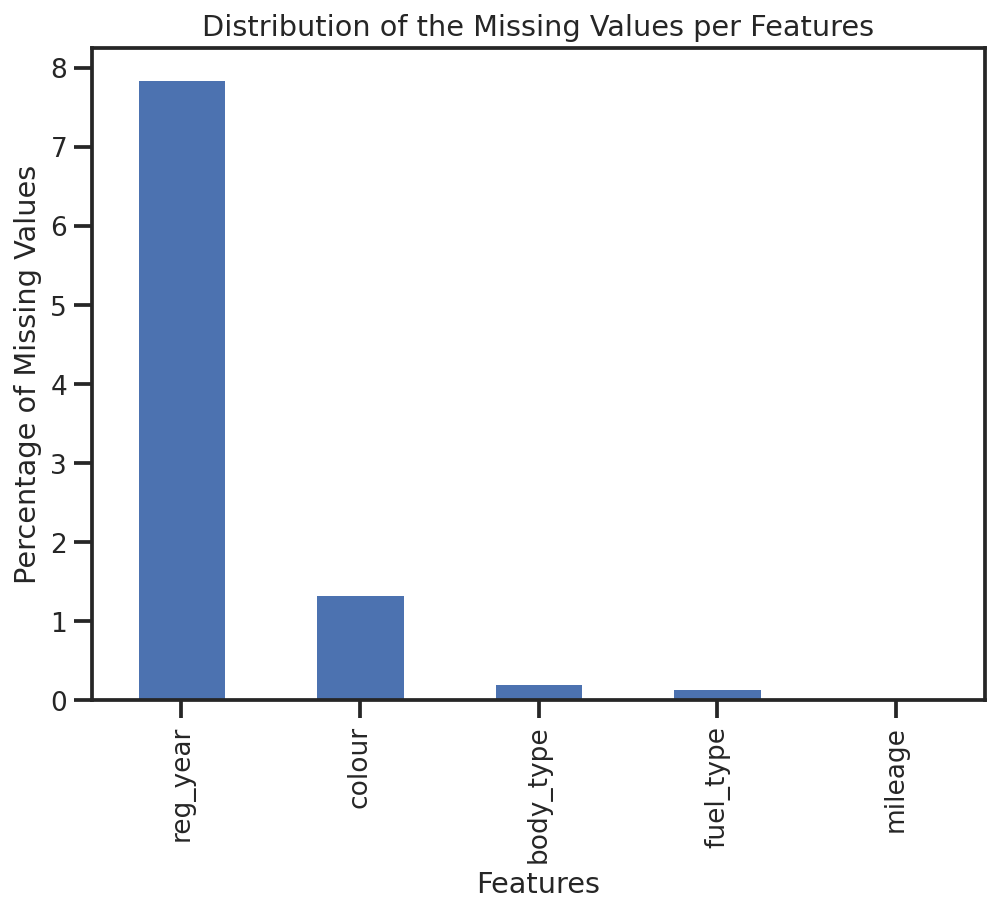

In [ ]:
print ("The number of the missing values per each feature is as follows:\n",auto_df.isnull().sum())
round((auto_df.isnull().sum()/len(auto_df))*100,2)[auto_df.isnull().sum()>0].sort_values(ascending=False).plot(
        kind="bar",
        title = "Distribution of the Missing Values per Features",
        xlabel = "Features",
        ylabel = "Percentage of Missing Values",
);

As shown, the `mileage, colour, reg_year, body_type, and fuel_type` are containing missing values with `reg_year` having the biggest ratio 
(~ 8%). To approach filling the missing values, I have to first understand their relation through the matrix plot below:

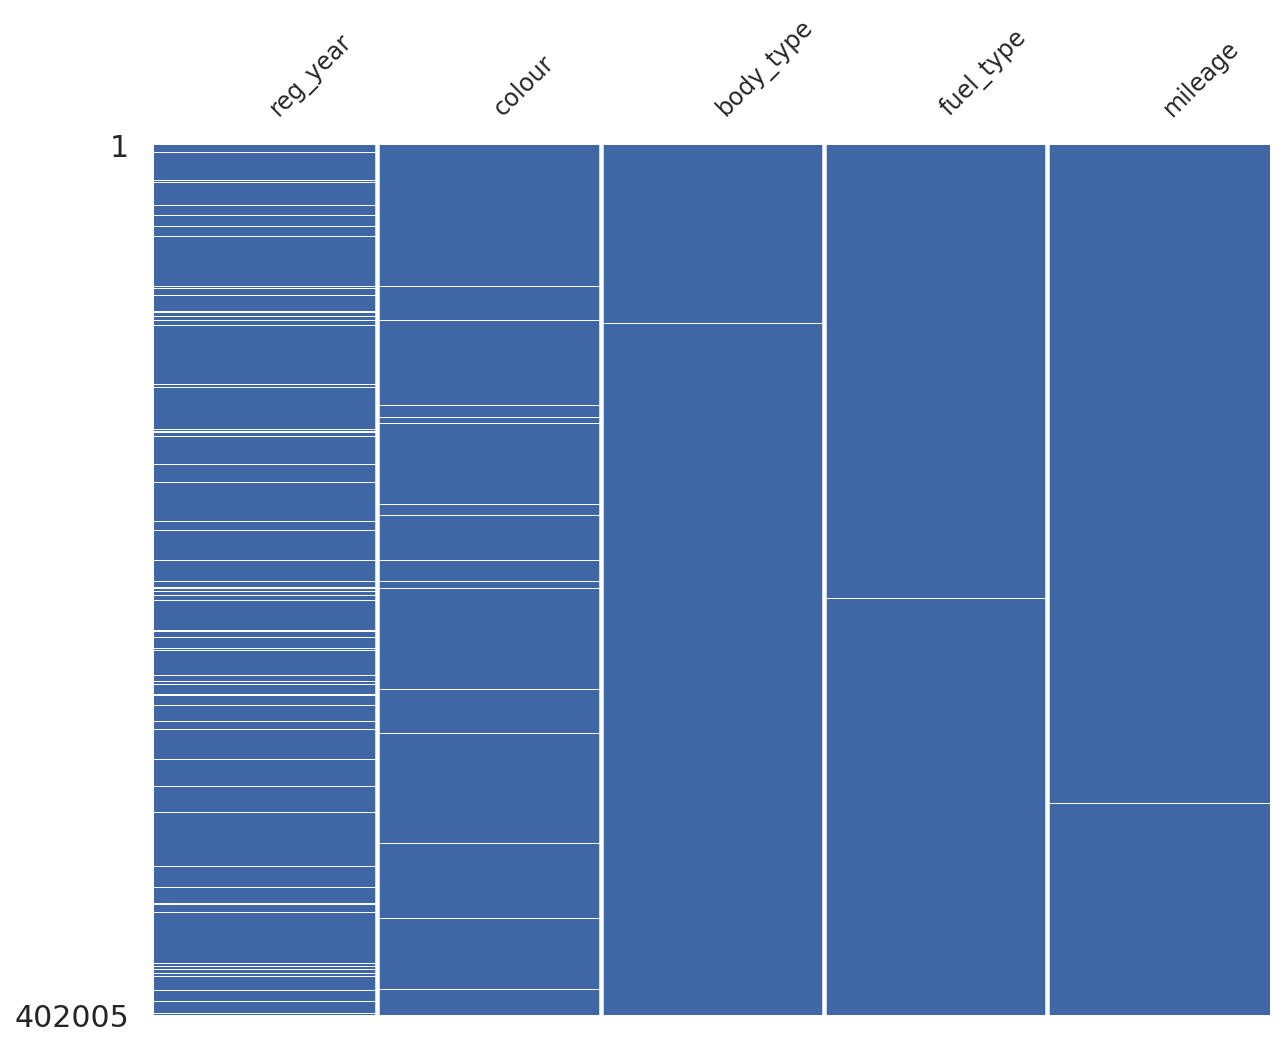

In [ ]:
msno.matrix(
    auto_df[['reg_year','colour','body_type','fuel_type','mileage']],
    sparkline=False,
    figsize=(10,8),
    fontsize=12,
    color = (0.250, 0.400, 0.650)
);

The figure above, shows that there are no significant relation between the missing values (e.g. the pattern of the missing values is arbitrary). Another test that I can depend to prove the randomness of the missing values is to visualize the correlation of the missing values using `msno.heatmap`.

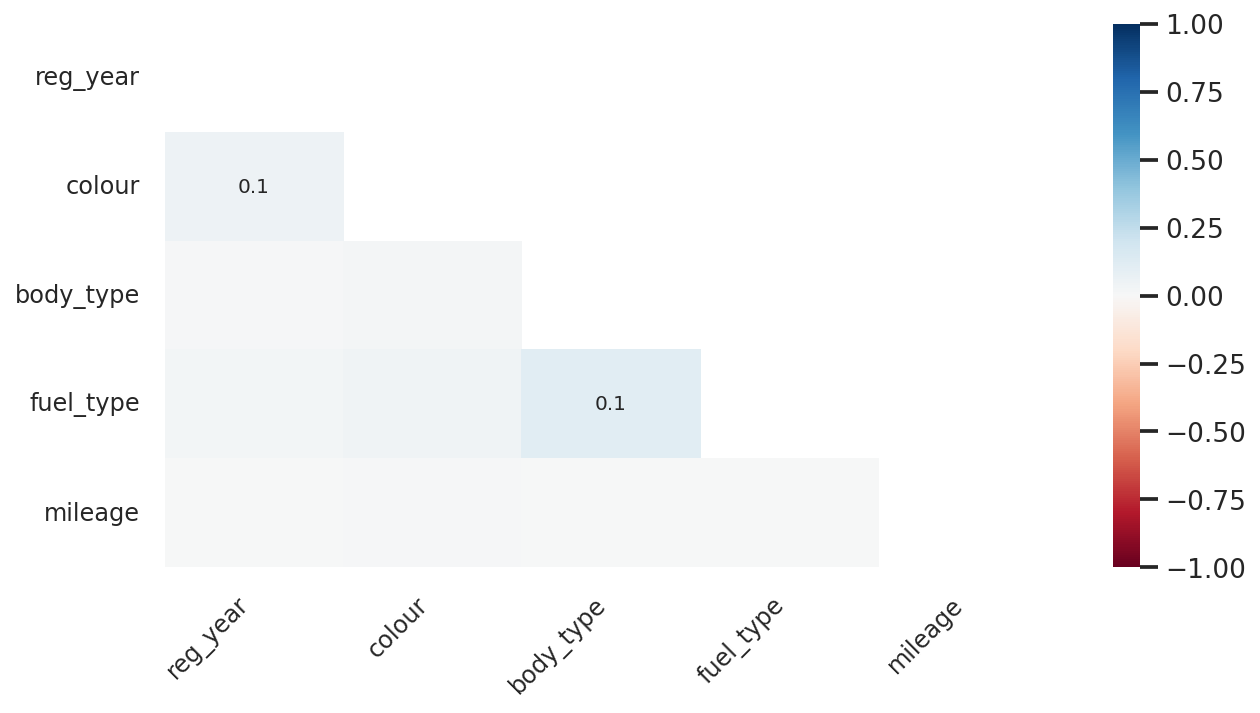

In [ ]:
msno.heatmap(
    auto_df[['reg_year','colour','body_type','fuel_type','mileage']],
    figsize=(10,5),
    fontsize=12
); 

From the figure above, I can see that there is a weak correlation (~ %10) between the features with missing values, henca I can say that the values are Missing completely at Random (MCAR).



#### 2.5.1 Registration Year

The ratio of missing values in `reg_year` is signiticantly higher than other features. I need to check if the missing data has any relation with the information in other features. The domain knowledge is playing a key role here, and saves us lots of time to determine the root cause of this issue. One possible cause is, NEW cars are usually not registered (hence, doesn't have the `reg_year`). Let's have a look at that:

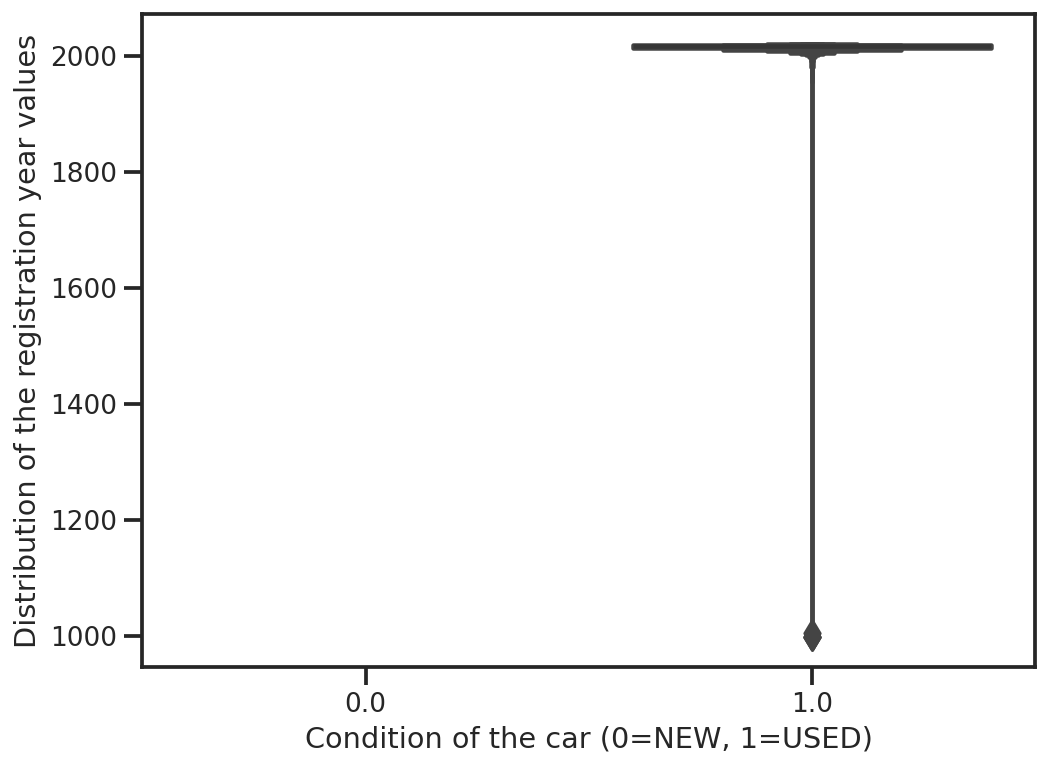

In [ ]:
sns.boxenplot(data = auto_df, x = 'condition', y = 'reg_year', palette = 'husl').set(
    xlabel = "Condition of the car (0=NEW, 1=USED)",
    ylabel="Distribution of the registration year values");

As we can see from the graph, there is no registration year recorded for the new cars. The most accurate approach is to fill the them with the most recent registration year of the cars. In another words, I fill the missing values with the maximum value of the registration year (which is 2020) as below: 

In [ ]:
auto_df["reg_year"].replace(np.nan, auto_df["reg_year"].max(), inplace=True)

#### 2.5.2 Mileage

In order to fill the missing values of the `mileage`, the quickest approach is to fill it in relation to the car's year of registration (`reg_year`). First let's understand the average distribution of `mileage` per each year:

```
# This is formatted as code
```

 

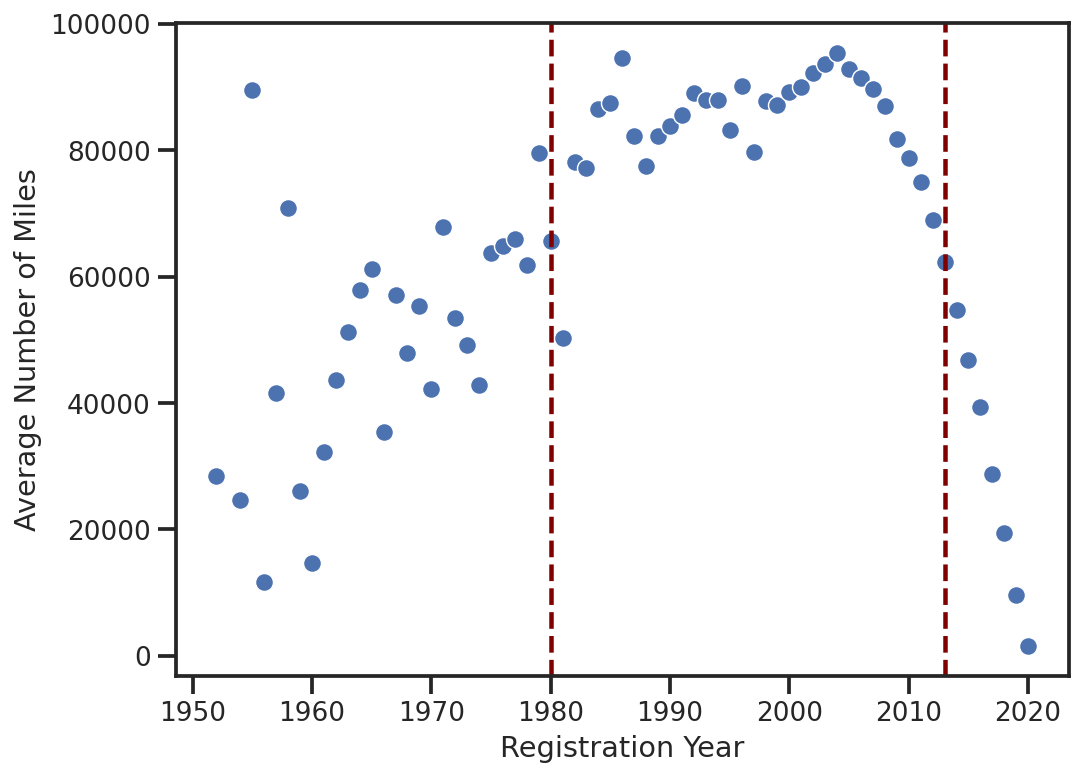

In [ ]:
sns.scatterplot(
    data = auto_df[(auto_df["reg_year"]>1950) & (auto_df["mileage"]<250000)].groupby(by="reg_year").mean(),
     x="reg_year", y="mileage"
).set(
    xlabel = "Registration Year",
    ylabel="Average Number of Miles");

plt.axvline(x = 1980, color ="maroon", linestyle ="--");
plt.axvline(x = 2013, color ="maroon", linestyle ="--");

As we can see from the graph, the cars between 1980 to 2013 (approximate) are having higher miles in average, while this number is droping significantly for the cars registered before 1980 and after 2015. 

In [ ]:
auto_df.loc[(((auto_df.reg_year>=1980) & (auto_df.reg_year<=2013)) & (auto_df.mileage.isnull())) , 'mileage'] = auto_df.loc[(auto_df.reg_year>=1980) & (auto_df.reg_year<=2013), 'mileage'] .mean()
auto_df.loc[(((auto_df.reg_year<1980) | (auto_df.reg_year>2013)) & (auto_df.mileage.isnull())) , 'mileage'] = auto_df.loc[((auto_df.reg_year<1980) | (auto_df.reg_year>2013)), 'mileage'] .mean()
auto_df.isnull().sum()

mileage         0
colour       5378
maker           0
model           0
condition       0
reg_year        0
price           0
body_type     837
crossover       0
fuel_type     601
dtype: int64

#### 2.5.3 Colour, Body Type, and Fuel Type

We have three categorical features (`colour`, `body_type`, `fuel_type`) left with having missing values. Our approach to handle those missing values will be the same which is to replace the null values with the categories in a random way.

As observed above, there are around 5,378 missing values in the car colours `colour`. To approach this, the number of observation should be identified for each colour in the dataset.

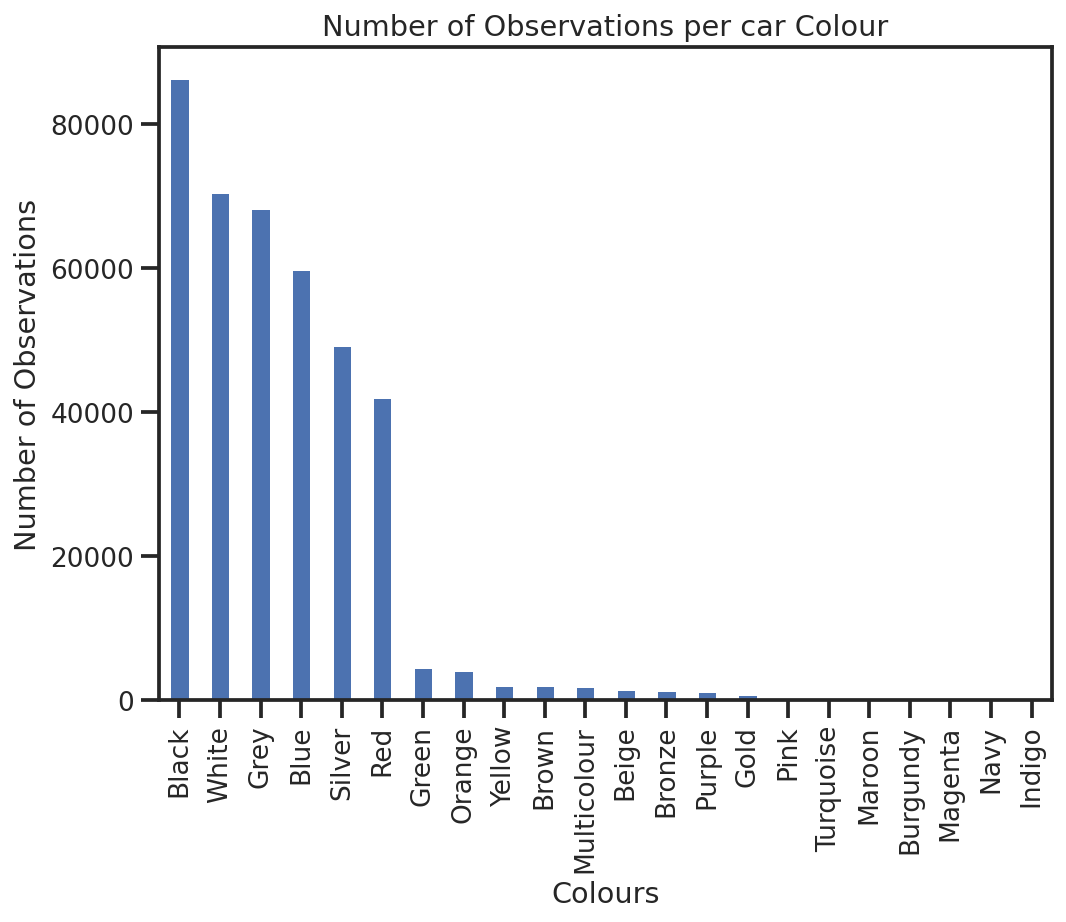

In [ ]:
auto_df.groupby(by = "colour").size().sort_values(ascending=False).plot(
        kind="bar",
        title = "Number of Observations per car Colour",
        xlabel = "Colours",
        ylabel = "Number of Observations",
);

We can see that `Black`, `White`, `Blue`, `Grey`, `Silver`, and `Red` cars are comprising around %80 of the total population. Hence, I replace the null values with those top 6 colours [randomly:](https://stackoverflow.com/questions/36413314/filling-missing-data-by-random-choosing-from-non-missing-values-in-pandas-datafr)


In [ ]:
top_6_colours = np.array (auto_df.groupby(by = "colour").size().sort_values(ascending=False).head(6).reset_index().colour) # Selecting top 6 colours

auto_df["colour"].fillna(random.choice(top_6_colours), inplace=True) # Randomly assigning top 6 colours to the NaN values

auto_df.isnull().sum() # Checking final results

mileage        0
colour         0
maker          0
model          0
condition      0
reg_year       0
price          0
body_type    837
crossover      0
fuel_type    601
dtype: int64

Both `body_type` and `fuel_type` have relatively low number of missing values, and I am using the same approach used to fill the missing values for `colour`.




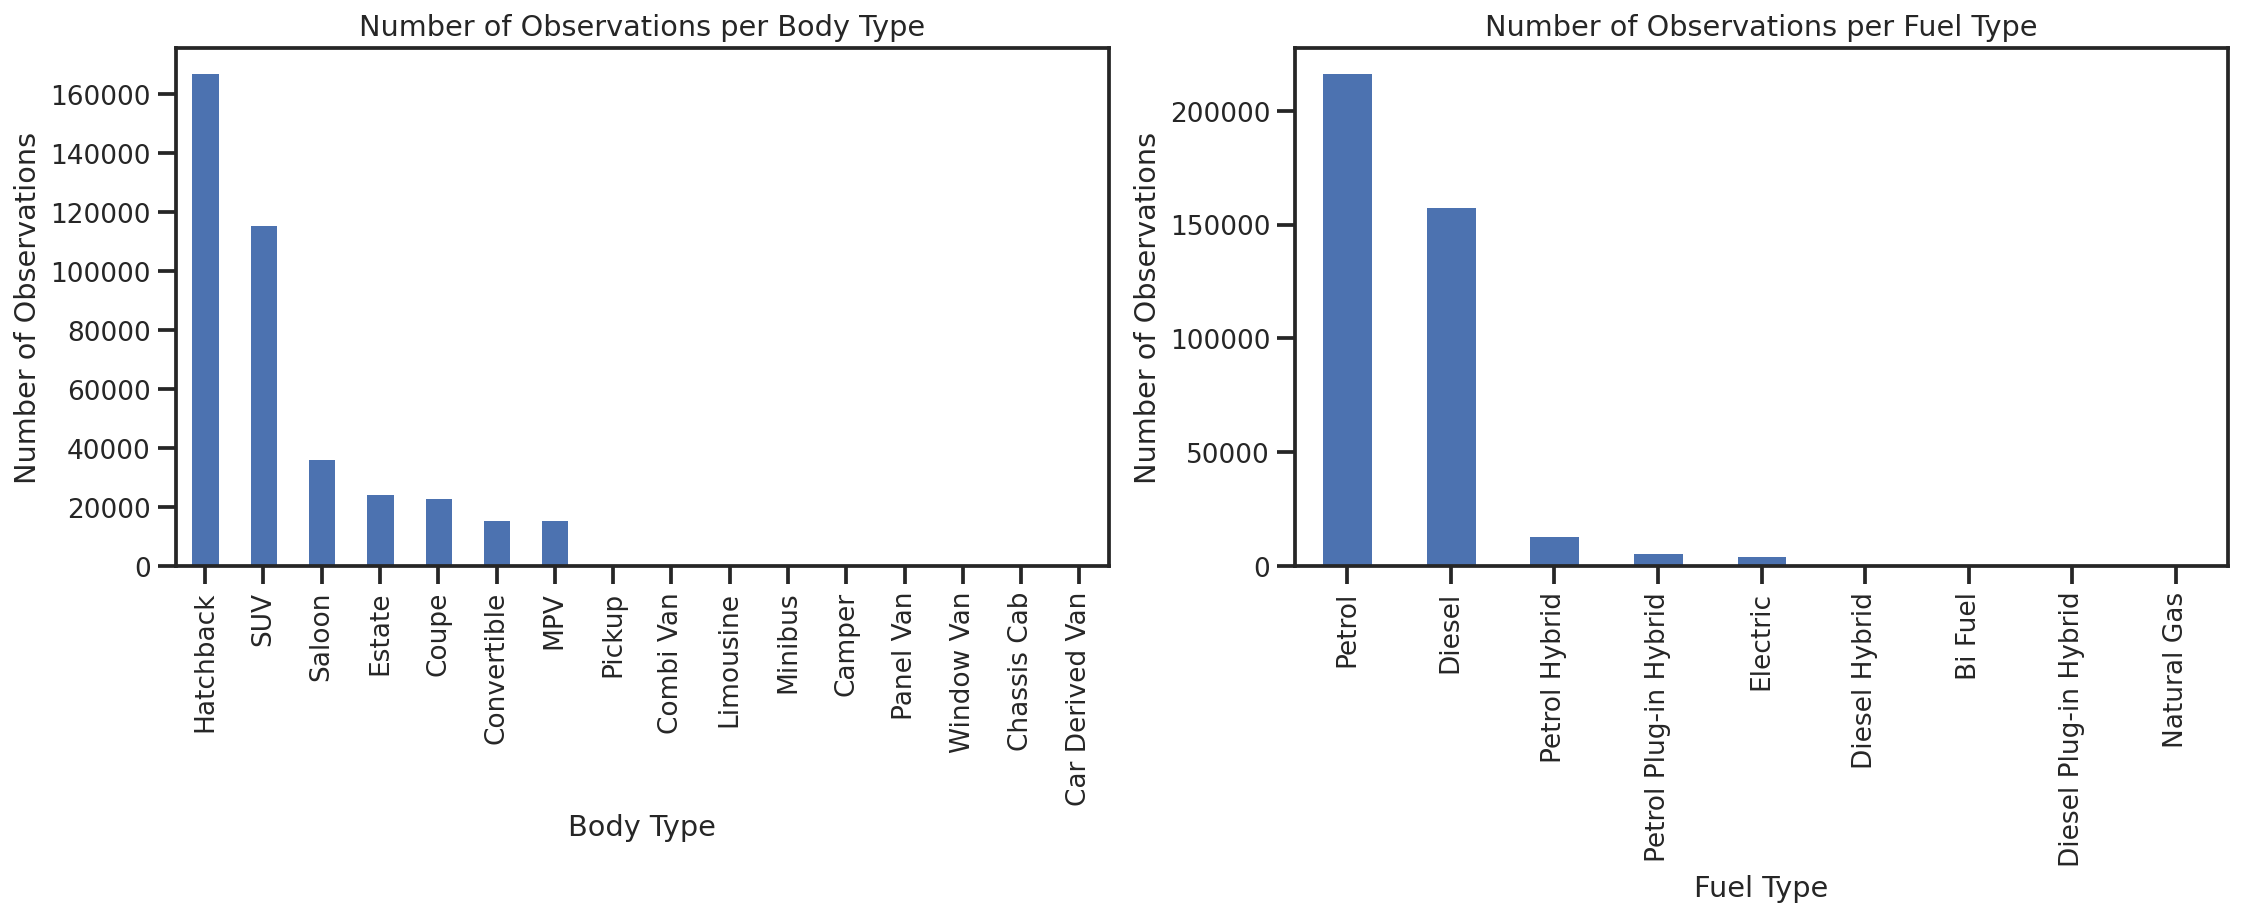

In [ ]:
plt.figure(figsize=(6, 4))
plt.subplots_adjust(bottom=0.1, right=2.5, top=1)

plt.subplot(1, 2, 1)
auto_df.groupby(by = "body_type").size().sort_values(ascending=False).plot(
        kind="bar",
        title = "Number of Observations per Body Type",
        xlabel = "Body Type",
        ylabel = "Number of Observations",
);

plt.subplot(1, 2, 2)
auto_df.groupby(by = "fuel_type").size().sort_values(ascending=False).plot(
        kind="bar",
        title = "Number of Observations per Fuel Type",
        xlabel = "Fuel Type",
        ylabel = "Number of Observations"
);

In [ ]:
top_7_bodyType = np.array (auto_df.groupby(by = "body_type").size().sort_values(ascending=False).head(7).reset_index().body_type)
auto_df["body_type"].fillna(random.choice(top_7_bodyType), inplace=True)
#--------------------------------------------------------------------------------------------------------------------------------
top_3_fuelType = np.array (auto_df.groupby(by = "fuel_type").size().sort_values(ascending=False).head(7).reset_index().fuel_type)
auto_df["fuel_type"].fillna(random.choice(top_3_fuelType), inplace=True)
#--------------------------------------------------------------------------------------------------------------------------------
auto_df.isnull().sum()

mileage      0
colour       0
maker        0
model        0
condition    0
reg_year     0
price        0
body_type    0
crossover    0
fuel_type    0
dtype: int64

### 2.6 Outliers

Some of the features are having abnormal values that are too extreme (outliers), and will affect the analysis and predictions. to better understand the outliers, let's look at the statistical information of the dataset:


In [ ]:
auto_df.describe()

,mileage,condition,reg_year,price,crossover
count,402005.000000,402005.000000,402005.000000,4.020050e+05,402005.000000
mean,37745.061332,0.922267,2015.402687,1.734197e+04,0.004465
std,34829.087783,0.267751,7.750857,4.643746e+04,0.066672
min,0.000000,0.000000,999.000000,1.200000e+02,0.000000
25%,10487.000000,1.000000,2014.000000,7.495000e+03,0.000000
50%,28623.000000,1.000000,2017.000000,1.260000e+04,0.000000
75%,56886.000000,1.000000,2018.000000,2.000000e+04,0.000000
max,999999.000000,1.000000,2020.000000,9.999999e+06,1.000000


From the statistical table above, I can see that there are some outliers in `mileage`, `reg_year`, and `price`. Let's explore each feature seperately: 

#### 2.6.2 Mileage

According to an article from [Housegrail](https://housegrail.com/car-longevity-statistics/), the average expected life span of a car is 200,000 miles, and with proper maintenance and good driving habits from the owner it can go upto 1,000,000 miles (very rare). In the AutoTrade dataset, I can see that there are many cars which their mileage are above the mentioned threshold. For this specific project, I take the median of 300,000 miles as a cap, and consider all the values above the threeshold as outliers.

There are 31 cars which their mileage is above 300,000


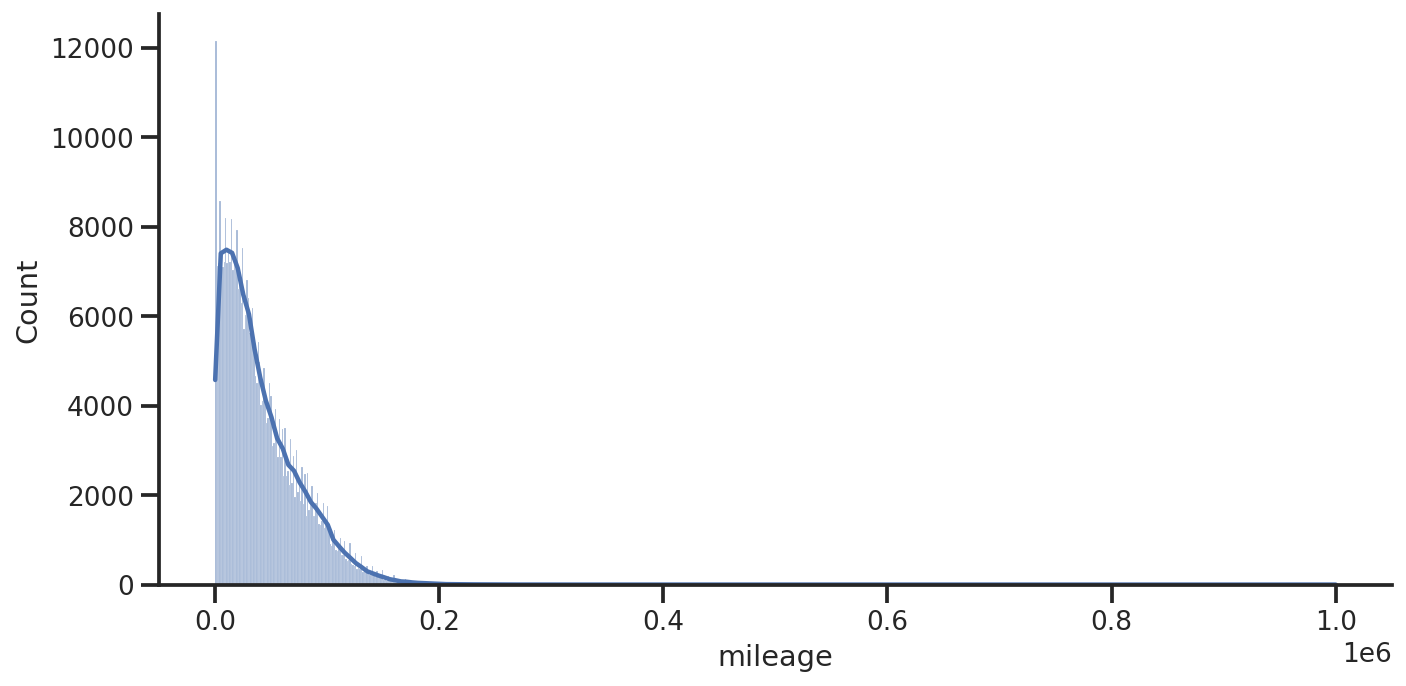

In [ ]:
sns.displot(auto_df[auto_df["mileage"]>10]['mileage'], kde=True, aspect=2);
print(f'There are {auto_df[auto_df["mileage"]>300000]["mileage"].size} cars which their mileage is above 300,000')

We change the mileage of those cars, with the mean value of the cars which their mileage are under 300,000 miles:

In [ ]:
auto_df.loc[auto_df["mileage"]>300000, "mileage"] = round(auto_df.loc[auto_df["mileage"]<300000, "mileage"].mean(), 0)

It is also important to identify any used car with 0 miles. 

In [ ]:
auto_df[(auto_df["mileage"]==0) & (auto_df["condition"]==1)].head()

,mileage,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,
202009254208702,0.0,Grey,Land Rover,Range Rover Velar,1.0,2020.0,52995.0,SUV,0.0,Diesel
202011015669636,0.0,Silver,Vauxhall,Insignia,1.0,2013.0,2975.0,Hatchback,0.0,Diesel
202010014447366,0.0,Grey,Mercedes-Benz,CLA Class,1.0,2020.0,34995.0,Estate,0.0,Petrol
202009304376426,0.0,Black,Land Rover,Range Rover,1.0,2020.0,82750.0,SUV,0.0,Diesel
202008283030532,0.0,Black,Audi,A1,1.0,2013.0,8000.0,Hatchback,0.0,Diesel


There are 355 car that are used but their mileage is 0. We can treat those values according to their `reg_year` as below: 

1. If the `reg_year` of the car is 2020, then this car is considered as new (`condition` == 0) 
2. If the `reg_year` of the car is less than 2020, then the mean of `mileage` would be assigned as a new mileage.

In [ ]:
auto_df.loc[(auto_df["mileage"]==0) & (auto_df["condition"]==1) & (auto_df["reg_year"]==2020), "condition"] = 0

auto_df.loc[(auto_df["mileage"]==0) & (auto_df["condition"]==1) & (auto_df["reg_year"]<=2019), "mileage"] = round(auto_df["mileage"].mean(),0)

# ############# Checking the Results ################

auto_df[(auto_df["mileage"]==0) & (auto_df["condition"]==1)].head()

,mileage,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,


#### 2.6.1 Registration Year

For the `reg_year`, there are some outliers in the dataset that are shown below:

In [ ]:
auto_df.loc[auto_df ['reg_year']<1920].head()

,mileage,colour,maker,model,condition,reg_year,price,body_type,crossover,fuel_type
pub_ref,,,,,,,,,,
202006270588110,14000.0,Blue,Toyota,Prius,1.0,1007.0,7000.0,Hatchback,0.0,Petrol Hybrid
202010155035879,96659.0,Black,Audi,A4 Avant,1.0,1515.0,10385.0,Estate,0.0,Diesel
202009163810376,37771.0,Black,Smart,fortwo,1.0,1063.0,4785.0,Coupe,0.0,Petrol
202008102305925,30000.0,Red,Toyota,AYGO,1.0,1009.0,4695.0,Hatchback,0.0,Petrol
202010064654489,27200.0,Black,MINI,Clubman,1.0,1016.0,18990.0,Estate,0.0,Diesel


To approach this I will follow the below steps:

1. Appearantly there is a typo error for the 4 digit of the `reg_year`s starting with one. For example a year of 1007 could be just 2007 (my best guess. I will replace the first digit of each year to 2 as follows:



In [ ]:
def year_corr(number): 

  if 1000<number<1930:
    number = str(number)
    number  = "2" + number[1:]
    number = float(number)
  elif (number>2030 or number<1000):
    number=round (auto_df["reg_year"].mean(), 0)
    
  if 1930 <= number <= 2020:
    return number
  else: 
    return round(auto_df["reg_year"].mean(),0)

auto_df['reg_year'] = auto_df['reg_year'].apply(year_corr)

#### 2.6.2 Price

Based on the `describe()` table above, there are a number of cars with exteremly high prices (up to 10 Million Pounds), as shown below: 

There are 32 cars which their price between 1-10 million pounds 



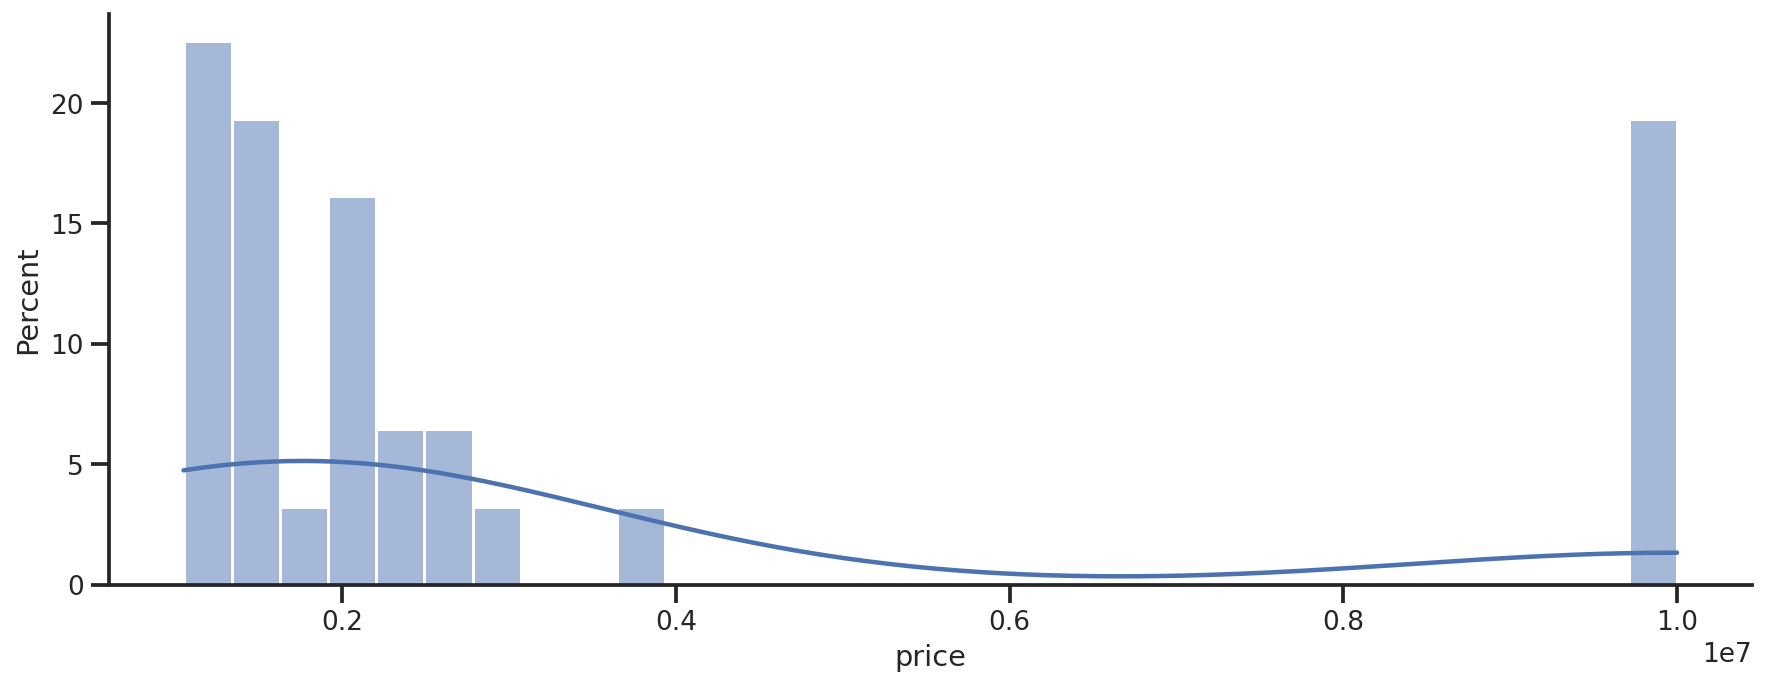

In [ ]:
print(f'There are {auto_df[auto_df["price"]>=1000000]["price"].size} cars which their price between 1-10 million pounds \n')
sns.displot(x = auto_df[auto_df["price"]>1000000]["price"],
            bins=auto_df[auto_df["price"]>1000000]["price"].size,
            stat='percent',
            kde=True,
            aspect=2.5
);

At this stage, it is important to further investigate the data, since some of the outliers might actually be genuine observations. I approach this issue by grouping the outliers by car makers:

In [ ]:
auto_df[auto_df["price"]>=1000000].groupby(by=["maker"]).size().sort_values(ascending=False).head(10)

maker
Ferrari          11
Bugatti           6
Porsche           6
McLaren           4
Lamborghini       1
Maserati          1
Aston Martin      1
Pagani            1
Mercedes-Benz     1
AC                0
dtype: int64

As we can see most of the highley priced cars are belonging to luxorious car brands. Hence, the price of those cars are potentially genuine. However, I have around 32 observations of such cars, which is less than %00001 of the total observations. To approach this issue, and for this project, I am capping those outliers with the maximum prices mentioned above (1,000,000) 

In [ ]:
auto_df.loc[auto_df["price"]>=1000000, "price"]=1000000

## Section 3: Exploratory Data Analysis

After cleaning the data, now it is time to explore the data and look deeper into the correlation of the features towards the target. Before that there are some cruicial questions that should be answered to understand the data: 

1. What are the best predictors of the price of a car? In other words, of the individual and interactions of pairs of features in the dataset, what are those that seem to have to strongest association with the feature price, and what are the explanations and insights behind those findings?
  * How strong is the association/correlation of the features with the target (price)?
  * How is the distribution of the categorical features with the target?

2.  What are interesting groupings of the data, involving one or two features that show significant differences (e.g., trends, averages) in price? What can we learn from them and how useful could these findings be for the business?
    * How the  average `price` changes per condition and body type of the cars?

### 3.1 How strong is the correlation of numerical features with the target (price)?

To answer this question we have to determine the correlation cooficient of each numerical feature (except the price outliers) towards the target through a heatmap: 

Reference: [The idea of masking the duplicate features is taken here.](https://stackoverflow.com/questions/57414771/how-to-plot-only-the-lower-triangle-of-a-seaborn-heatmap)

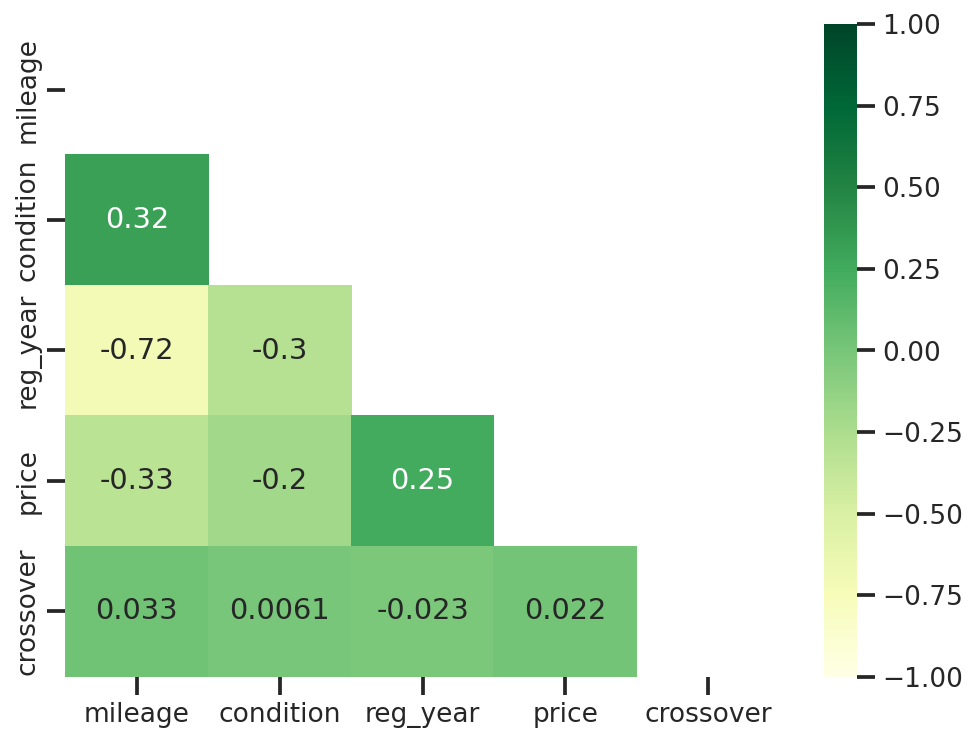

In [ ]:
corr_data = auto_df.loc[:, auto_df.columns != "price_outlier"].corr()
mask = np.triu(corr_data)
sns.heatmap(data=corr_data, vmin=-1, vmax=1, annot=True, cmap="YlGn", mask = mask);

We can observe there is a weak relatioship between the numerical features and the target. 

To conclude: 

1. `mileage` and `reg_year` have the strongest correlation with `price` which are %16 and %12 accordingly. This means that higher the `mileage`, the lower `price` will become. Also, the cars with recent registration year have higher price.
2.  The `mileage` is strongly affected by the `reg_year` (%70) and `condition` (%30) of the car. Interestingly, the USED cars with older registration year (before 1980) are having less mileag (explained above)




Now we look at the distribution of the `mileage` and the `price` of the cars per year of registration: 



>❗To simplify the visualization, I am removing the **outliers** and take the subset of the data.




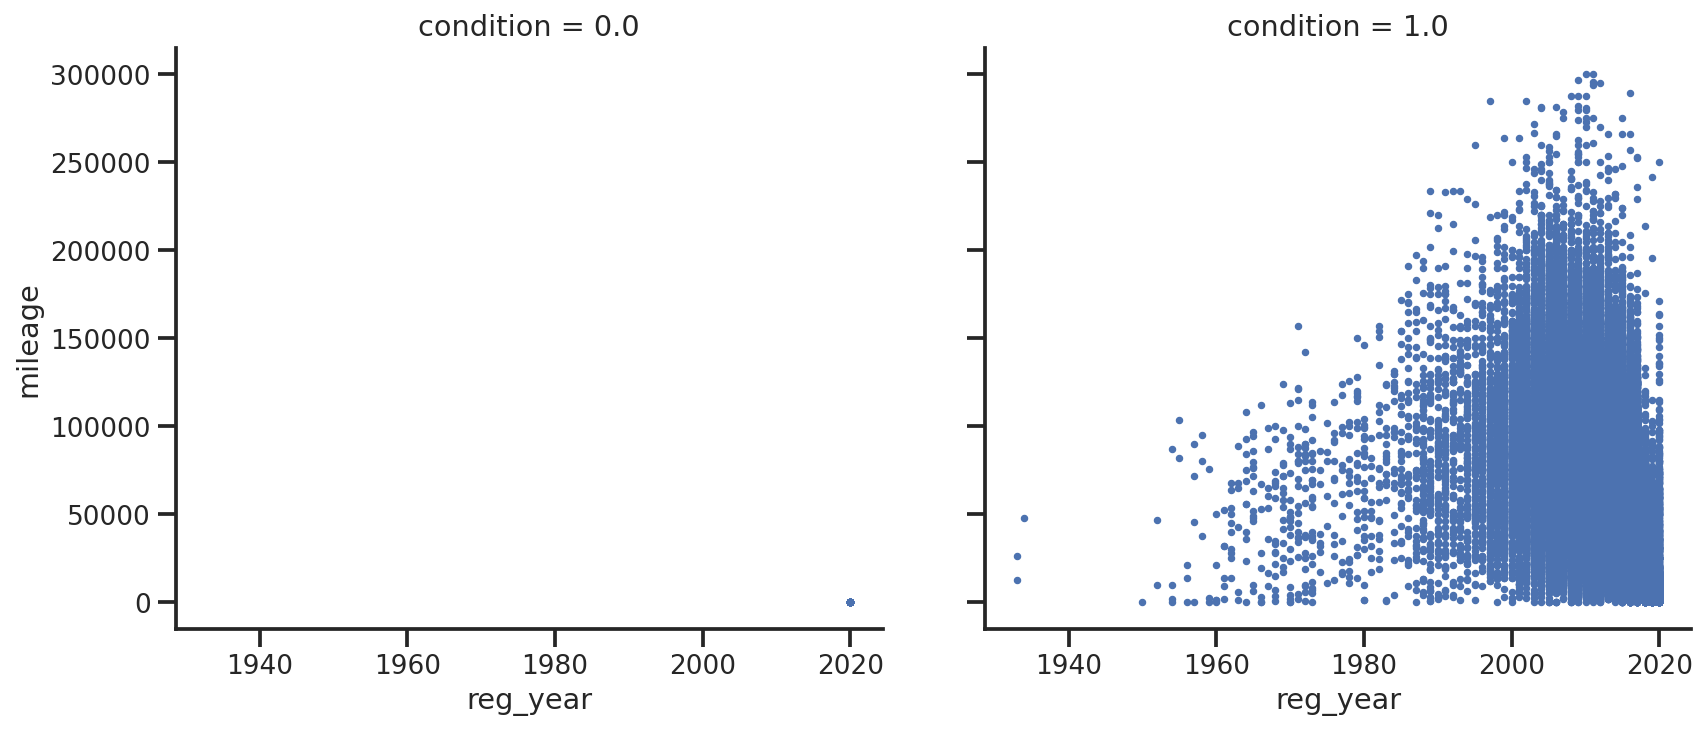

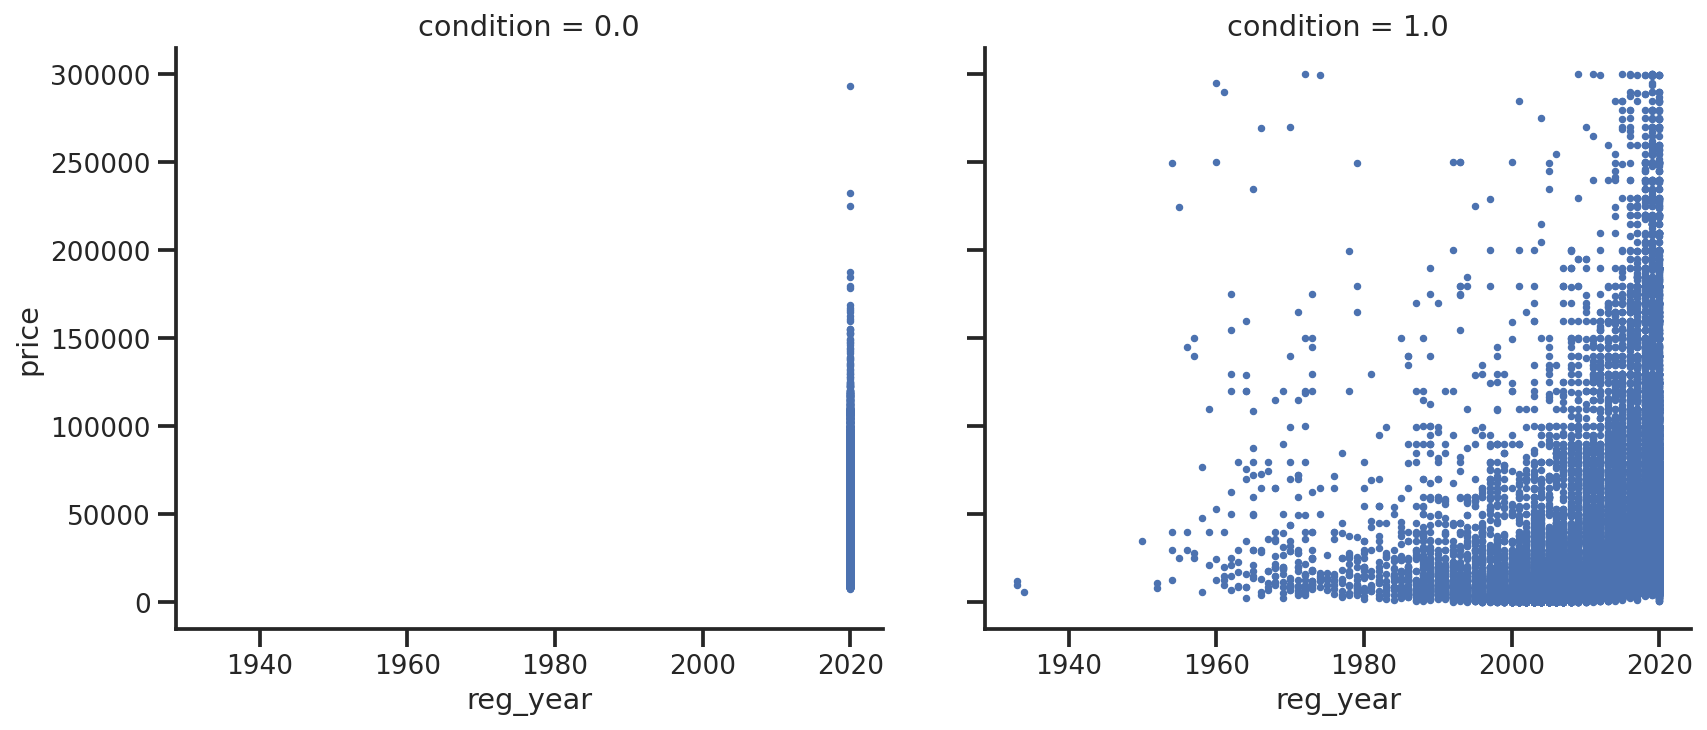

In [ ]:
g = sns.FacetGrid(data=auto_df[(auto_df["price"]<300000) & (auto_df["mileage"]<500000)], col='condition', col_wrap=4)
g = g.map(plt.scatter, 'reg_year', 'mileage', s=5)
g.fig.set_size_inches(25,7)
#---------------------------------------------------------------------------------------------------------------------
g = sns.FacetGrid(data=auto_df[(auto_df["price"]<300000) & (auto_df["mileage"]<500000)], col='condition', col_wrap=4)
g = g.map(plt.scatter, 'reg_year', 'price', s=5)
g.fig.set_size_inches(25,7)


As we can see that `reg_year` has a linear with a `price` but non-linear corelation with the `mileage`. 

### 3.2 How is the distribution of the categorical features with the target?

One more thing I can explore is the distribution of  some of the features (`colour`, `maker`, `fuel_type` and `body_type`) with the target (`price`). Through this, I can check how each individual categorical feature is affecting the price of the car. 

As I have observed above, the **Black, White, Grey, Blue, Silver, and Red** are the majority. This can be visualized through a heatmap below: 

>❗To simplify the visualization, I am removing the **outliers** and take the subset of the data.

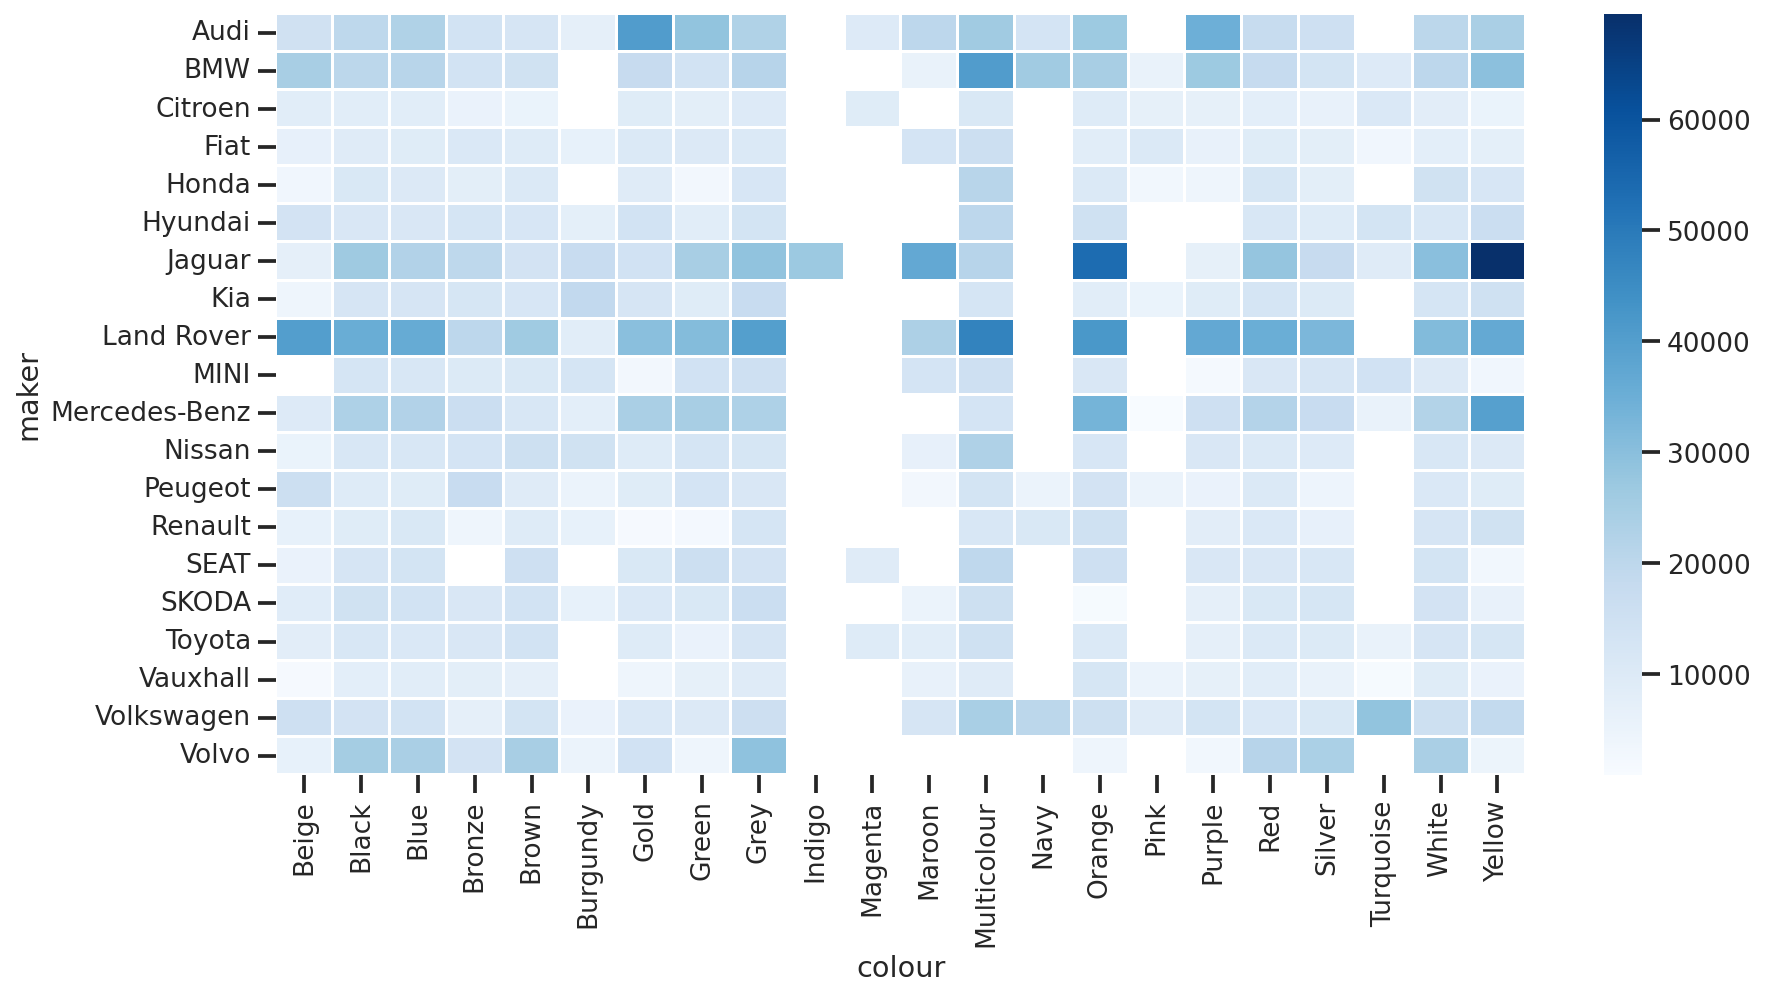

In [ ]:
top_makers = auto_df.groupby(["maker"]).size().sort_values(ascending=False).head(20).index.tolist() #Identifying top 20 car makers
df_heatmap = auto_df[(auto_df["maker"].isin(top_makers))].copy() # Masking the data for the top 10 car makers
df_heatmap = df_heatmap[["maker","colour","price"]].pivot_table(index='maker', columns='colour', values="price", aggfunc=np.mean, sort=True) # pivoting the data together
plt.figure(figsize = (14,7))
sns.heatmap(df_heatmap, linewidths=1, cmap="Blues");

Interestingly, the Land Rover, Jaguar, Audi and BMW with Yellow, Milticolor and Organge colors have the highest average prices. <br></br>

One more important exploration I can do is to check the relation of fuel type and body type with the price of the vechicles: 

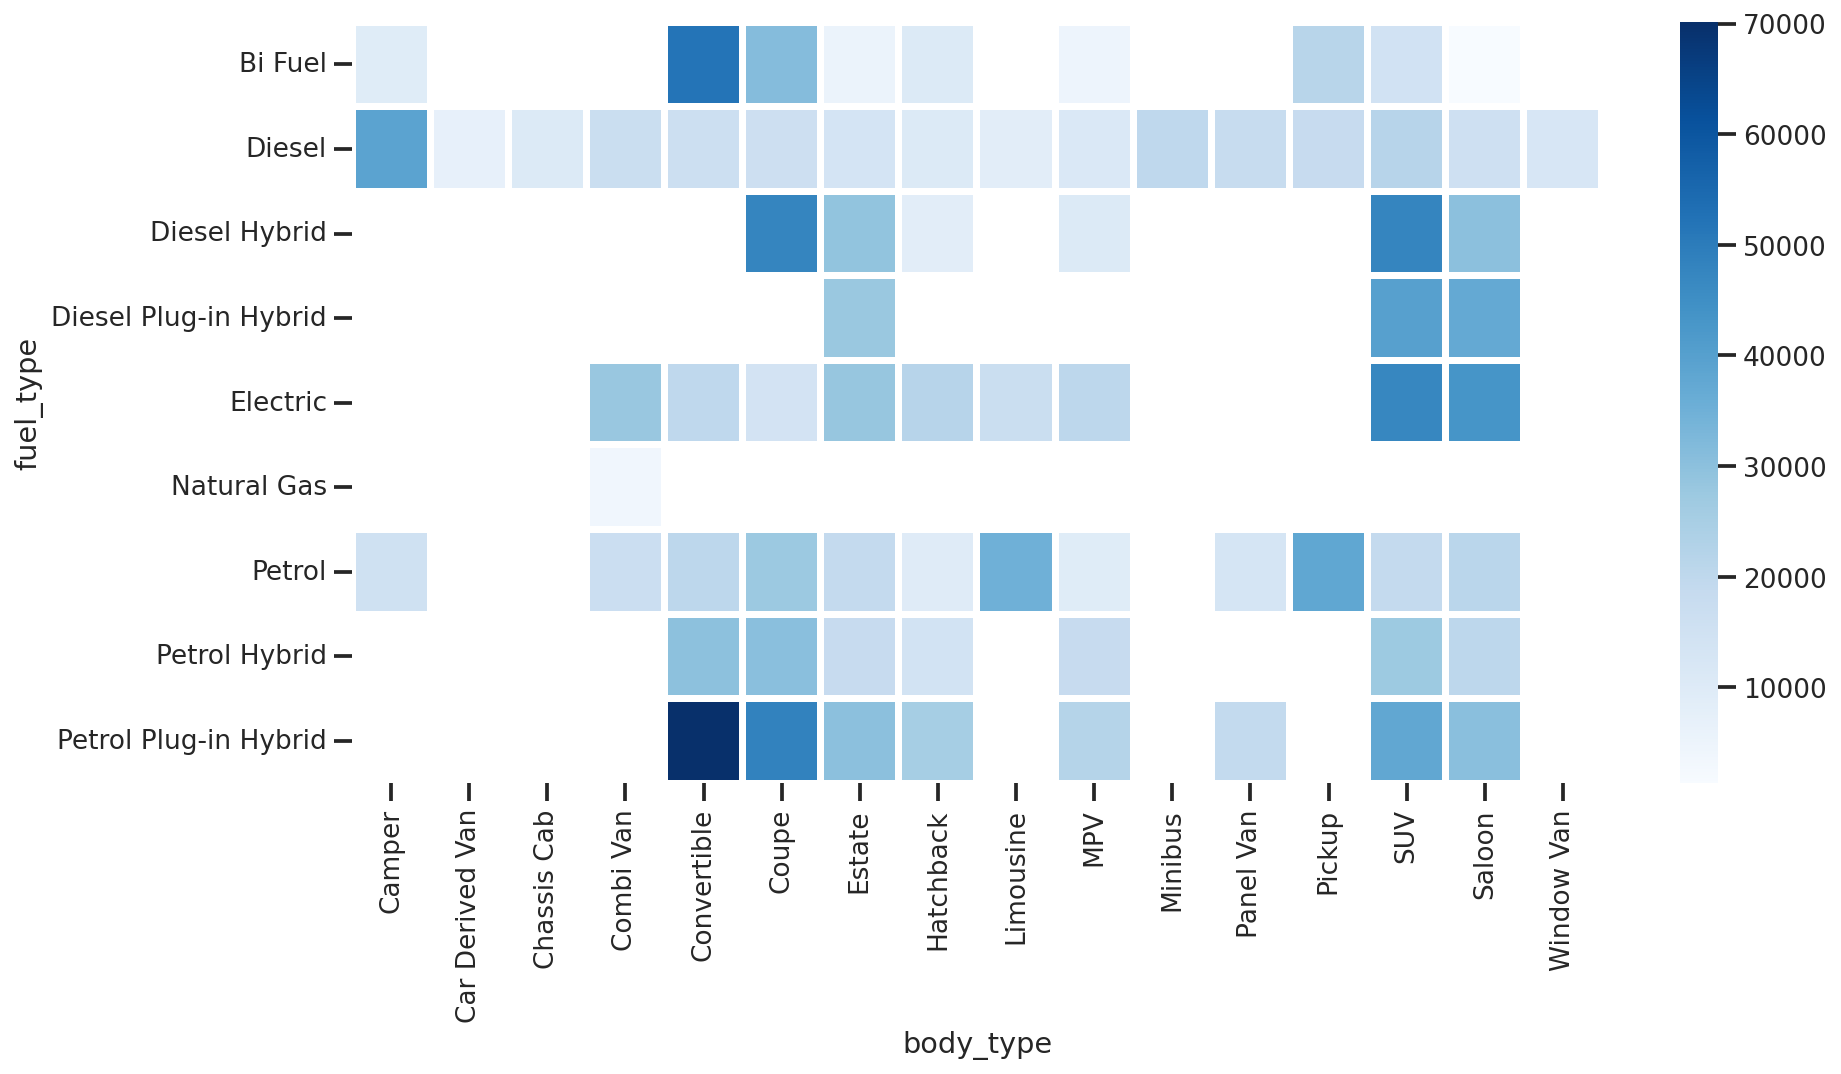

In [ ]:
df_heatmap = auto_df[auto_df["price"]<100000].copy()
df_heatmap = df_heatmap[["fuel_type","body_type","price"]].pivot_table(
    index='fuel_type', columns='body_type', values="price", aggfunc=np.mean )

plt.figure(figsize = (14,7))
sns.heatmap(df_heatmap, linewidths=3, cmap="Blues");

**From the figure above, we can see that:**

1. Both Petrol and Diesel (hybrid/non-hybrid) cars are having highest average prices across the other car colours.
2. The convertables, coupe, estate, SUV, and Saloon cars are having the hihest average price across the other car types.

### 3.3 How condition and body type of the car affect the target?

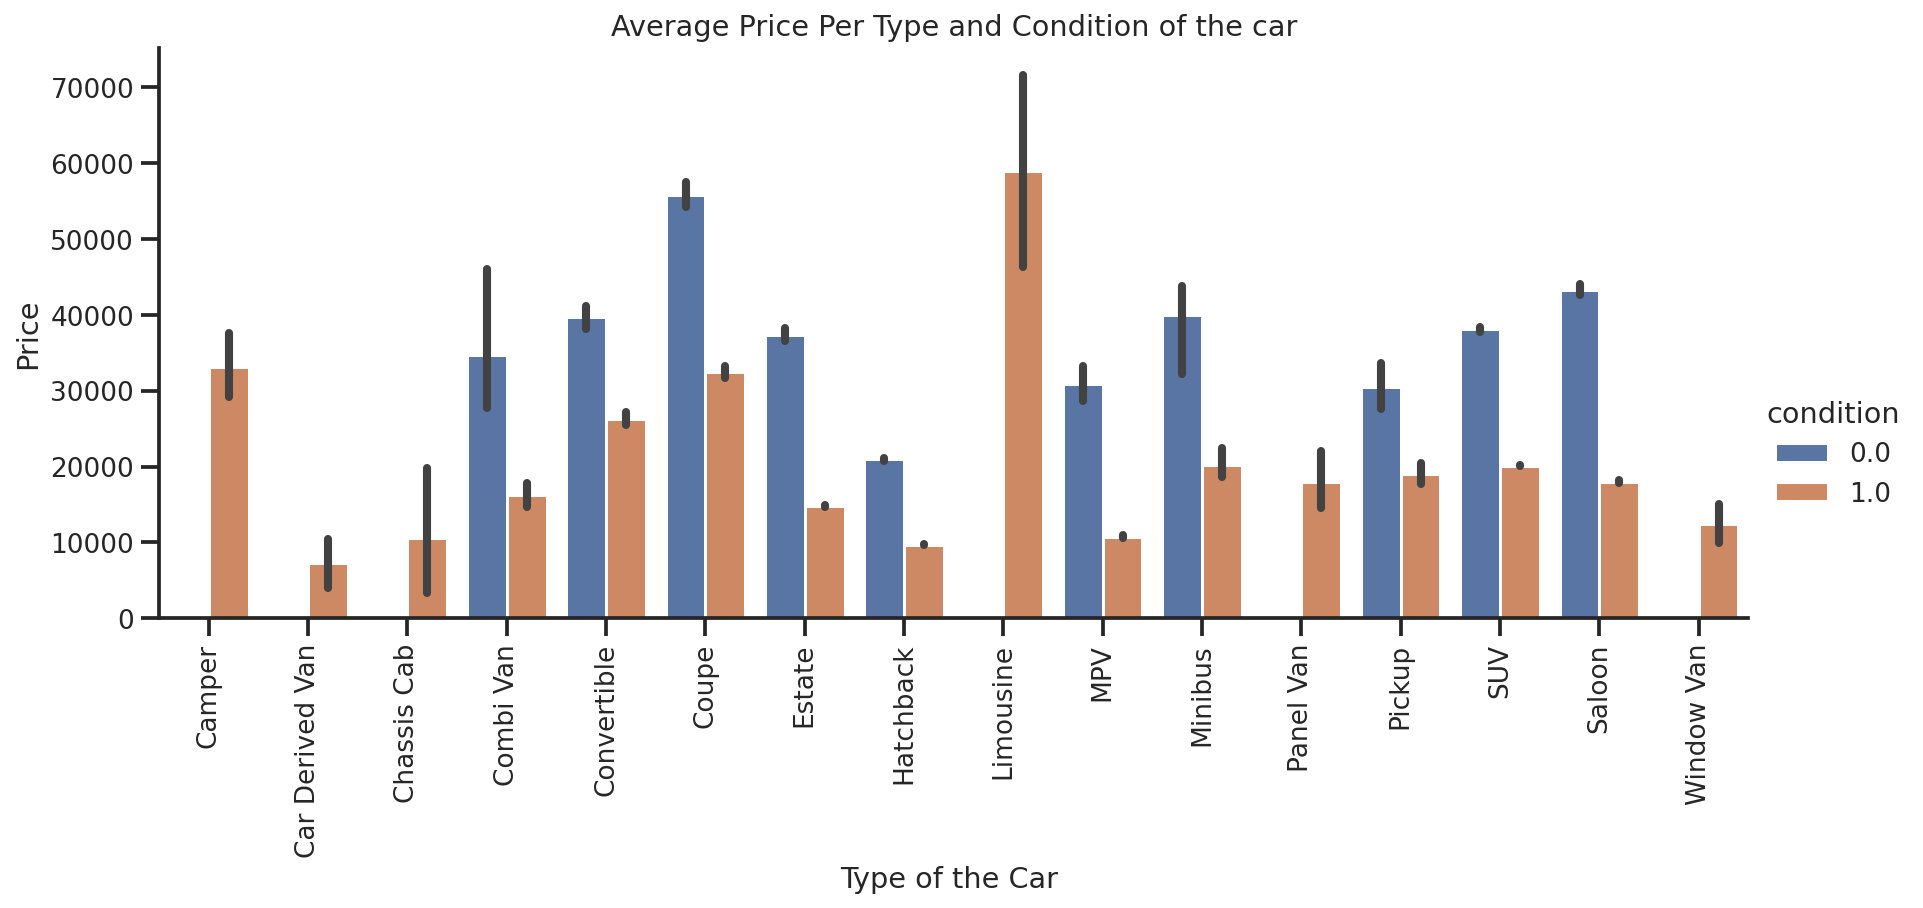

In [ ]:
plot = sns.catplot(data=auto_df,
            x="body_type",
            y="price",
            hue="condition",
            kind="bar",
            aspect = 2.5,
);

plot.set(
    title = 'Average Price Per Type and Condition of the car',
    xlabel = "Type of the Car ",
    ylabel= "Price",
)
plot.set_xticklabels(rotation= 90);

To concludde:

1. The average price of the New Cars are usually higher than the Used Cars. 
2. There is a noticeable variance between the average price of the used vs. new cars. 

## Section 4: Feature Transformation

After cleaning and understanding the dataset, now I have to start transforming our data to be used for predictions. As mentioned earlier, there are 5 categorical features that are not interpretable by our 
Machine Learning algorithm. Hence, I have to handle those categorical features, and transform them to numerical value. There are different transformation approaches and their usage depends on the distribution and frequency of our categorical values. Let's first recall the column types and the number of categorical values per each feature below

In [ ]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 402005 entries, 202006039777689 to 201512149444029
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   mileage    402005 non-null  float64 
 1   colour     402005 non-null  category
 2   maker      402005 non-null  category
 3   model      402005 non-null  category
 4   condition  402005 non-null  float64 
 5   reg_year   402005 non-null  float64 
 6   price      402005 non-null  float64 
 7   body_type  402005 non-null  category
 8   crossover  402005 non-null  float64 
 9   fuel_type  402005 non-null  category
dtypes: category(5), float64(5)
memory usage: 28.8 MB


In [ ]:
auto_df[categorical_features].describe()

,colour,maker,model,body_type,fuel_type
count,402005,402005,402005,402005,402005
unique,22,110,1168,16,9
top,Black,BMW,Golf,Hatchback,Petrol
freq,86287,37376,11583,167315,216929


#### 4.1 Target Encoder
We can see that there are 5 categorical features with high cardinality. To approach this specific issue, I can't use a simple encoder like one-hot-encoder since this will generate many columns. Instead, I use `Target Encoder` which "*features are replaced with a blend of posterior probability of the target given particular categorical value and the prior probability of the target over all the training data*" as stated from the Scikit Learn website [here](https://https://contrib.scikit-learn.org/category_encoders/targetencoder.html). 


> The major problem with this approach is data/target leakage, which refers to the leakage of data between the train and test data. An effective way to prevent the data leakage is to split test and train data before transformation.

> I don't need to scale the features as Random Forest Regression is not distance-based algorithm.

To start with our data transformation, first I need to split the train and test data as follows: 

In [ ]:
X = auto_df.drop(columns='price')
y = auto_df['price']

auto_X_train, auto_X_test, auto_y_train, auto_y_test = train_test_split(X, y, test_size=0.20)

Then, I am going to apply the `fit_transform` on the train data, but `transform` only on the test data. This will help us further minimize the leakage between the train and test features.

In [ ]:
encoder = TargetEncoder();
auto_X_train = encoder.fit_transform(X = auto_X_train, y = auto_y_train, return_df=True);
auto_X_test = encoder.transform(X = auto_X_test, y = auto_y_test);

Checking datatypes in train and test data:

In [ ]:
auto_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321604 entries, 202010215281921 to 202009183912916
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   mileage    321604 non-null  float64
 1   colour     321604 non-null  float64
 2   maker      321604 non-null  float64
 3   model      321604 non-null  float64
 4   condition  321604 non-null  float64
 5   reg_year   321604 non-null  float64
 6   body_type  321604 non-null  float64
 7   crossover  321604 non-null  float64
 8   fuel_type  321604 non-null  float64
dtypes: float64(9)
memory usage: 24.5 MB


In [ ]:
auto_X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80401 entries, 202009043328634 to 202004068873880
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    80401 non-null  float64
 1   colour     80401 non-null  float64
 2   maker      80401 non-null  float64
 3   model      80401 non-null  float64
 4   condition  80401 non-null  float64
 5   reg_year   80401 non-null  float64
 6   body_type  80401 non-null  float64
 7   crossover  80401 non-null  float64
 8   fuel_type  80401 non-null  float64
dtypes: float64(9)
memory usage: 6.1 MB


#### 4.2 Cars with Single Observation

> **One interesting test we can make here is to check the outcome of the transformer against the original dataset**


To do this, I transform the whole dataset then compare the `maker` feature before and after transformation

In [ ]:
print(f'There are {(auto_df["maker"].value_counts() == 1).sum()} signle-value categories before the transformation\n')

There are 19 signle-value categories before the transformation



In [ ]:
enc_test = TargetEncoder();
auto_transformed_df = enc_test.fit_transform(X = auto_df.drop(columns="price"), y = auto_df["price"], return_df=True);

print(f'There are {(auto_transformed_df["maker"].value_counts() == 1).sum()} signle-value categories after the transformation\n')

There are 15 signle-value categories after the transformation



**As we can see above, we have 19 car makers that have single observation in the original dataset. However, after encoding those single observations are ommited. My guess is, those observations are considered with the same weight, hence the TargetEncoder gave them the same label** 

> **I could have deleted the cars that are advertised only once, but I will make the deision after testing the importancy of the features**

## Section 5: Feature Selection



Feature selection is the process of choosing the most important or relevant features from a dataset to use in a model. This is done in order to improve the accuracy and interpretability of the model while reducing overfitting and computational cost. The idea behind feature selection is to keep only the most informative features or categories in the dataset to train the model and make the predictions. To determine the importancy of our features, I will be using the following approaches: 

1. Determining the **Multicollinearity** using correlation, and highlighting the columns that are highly correlated.
3. `SelectKBest` which is based on univariate statistical tests (`chi2` test, in this case) from `sci-kit learn` feature selection library [Source](https://www.geeksforgeeks.org/ml-chi-square-test-for-feature-selection/)

> Later in the Machine Learning part of this project, I will be using SHAP (SHapley Additive exPlanations) which is a detailed method for representing importancy of features. SHAP is based on the concept of Shapley values from cooperative game theory.

#### 5.1 Multicolliniarity
To check the Multicolliniarity, I will be using the same dataset encoded above `auto_transformed_df` as it cointains both train and test data (excluding the target `price`)

Text(0.5, 1.0, 'Standard Correlation Coefficient')

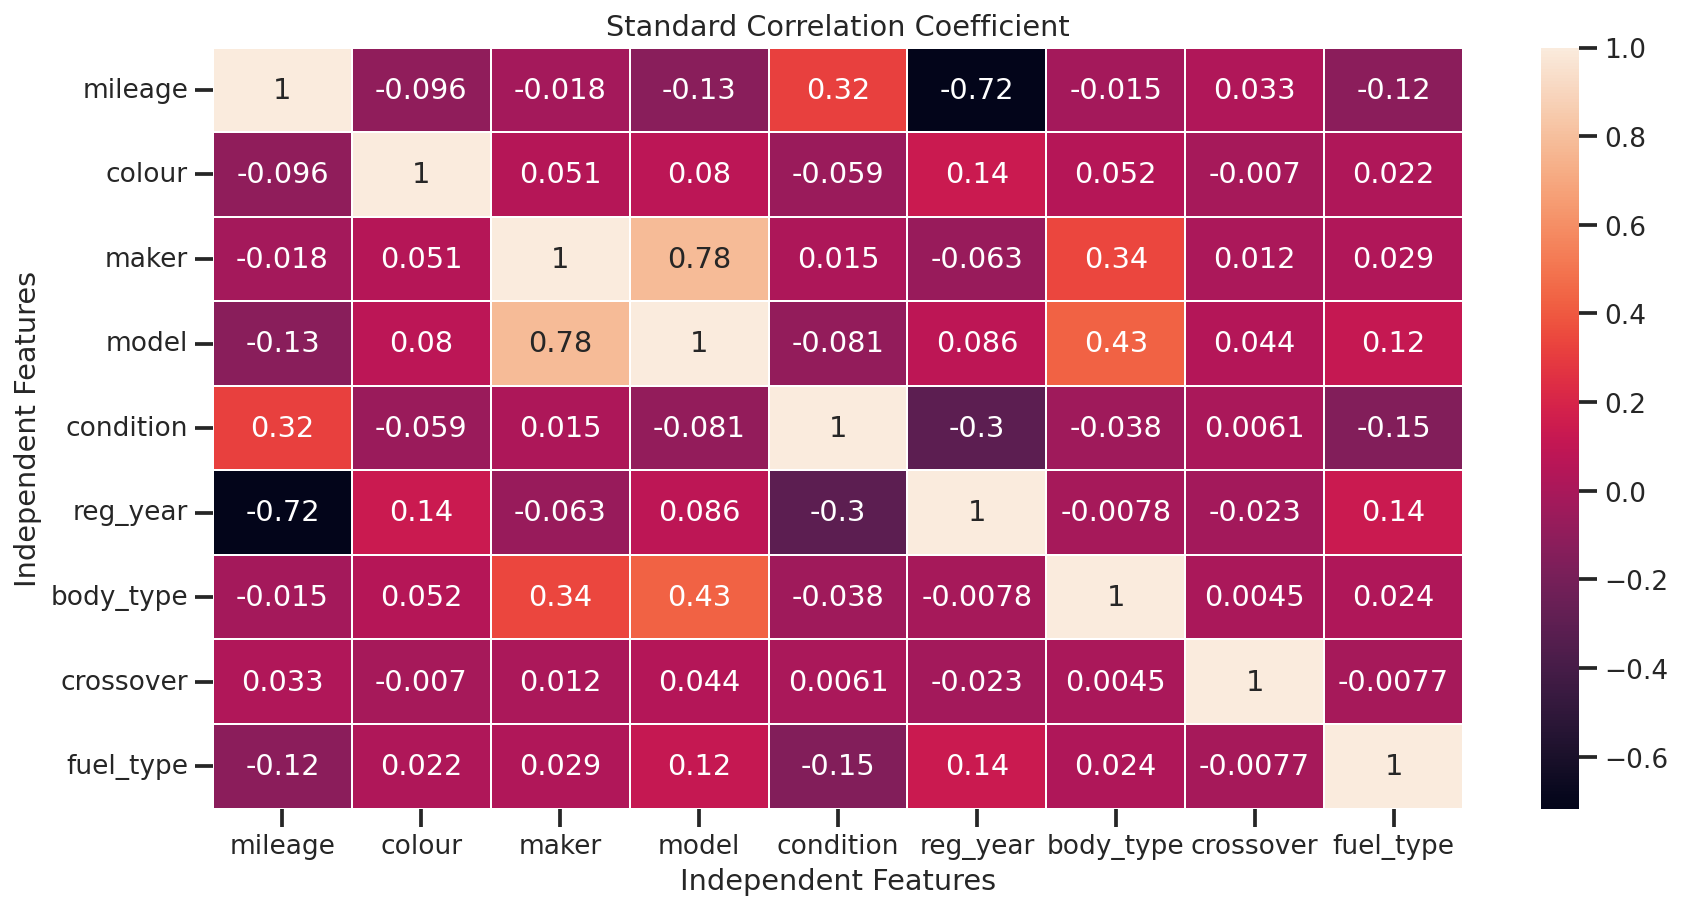

In [ ]:
plt.figure(figsize = (14,7))
g = sns.heatmap(auto_transformed_df.corr(), annot=True, linewidth=0.5);
g.set_xlabel("Independent Features")
g.set_ylabel("Independent Features")
g.set_title("Standard Correlation Coefficient")

Fromt the figure above, I can conclude that: 
1. `model` and `maker` have a 75% positive correlation
2. `mileage` and `reg_year` have 72% negative correlation. 

This means that the pair of features mentioned above will have the similar effect on the output of the model (since they have the same magnitude). I perform some more testing below to further confirm their importance.

#### 5.2 Univariate Statistical Test

*Chi Square determines if the association between two categorical variables of the sample would reflect their real association in the population* [source](https://www.geeksforgeeks.org/ml-chi-square-test-for-feature-selection/)

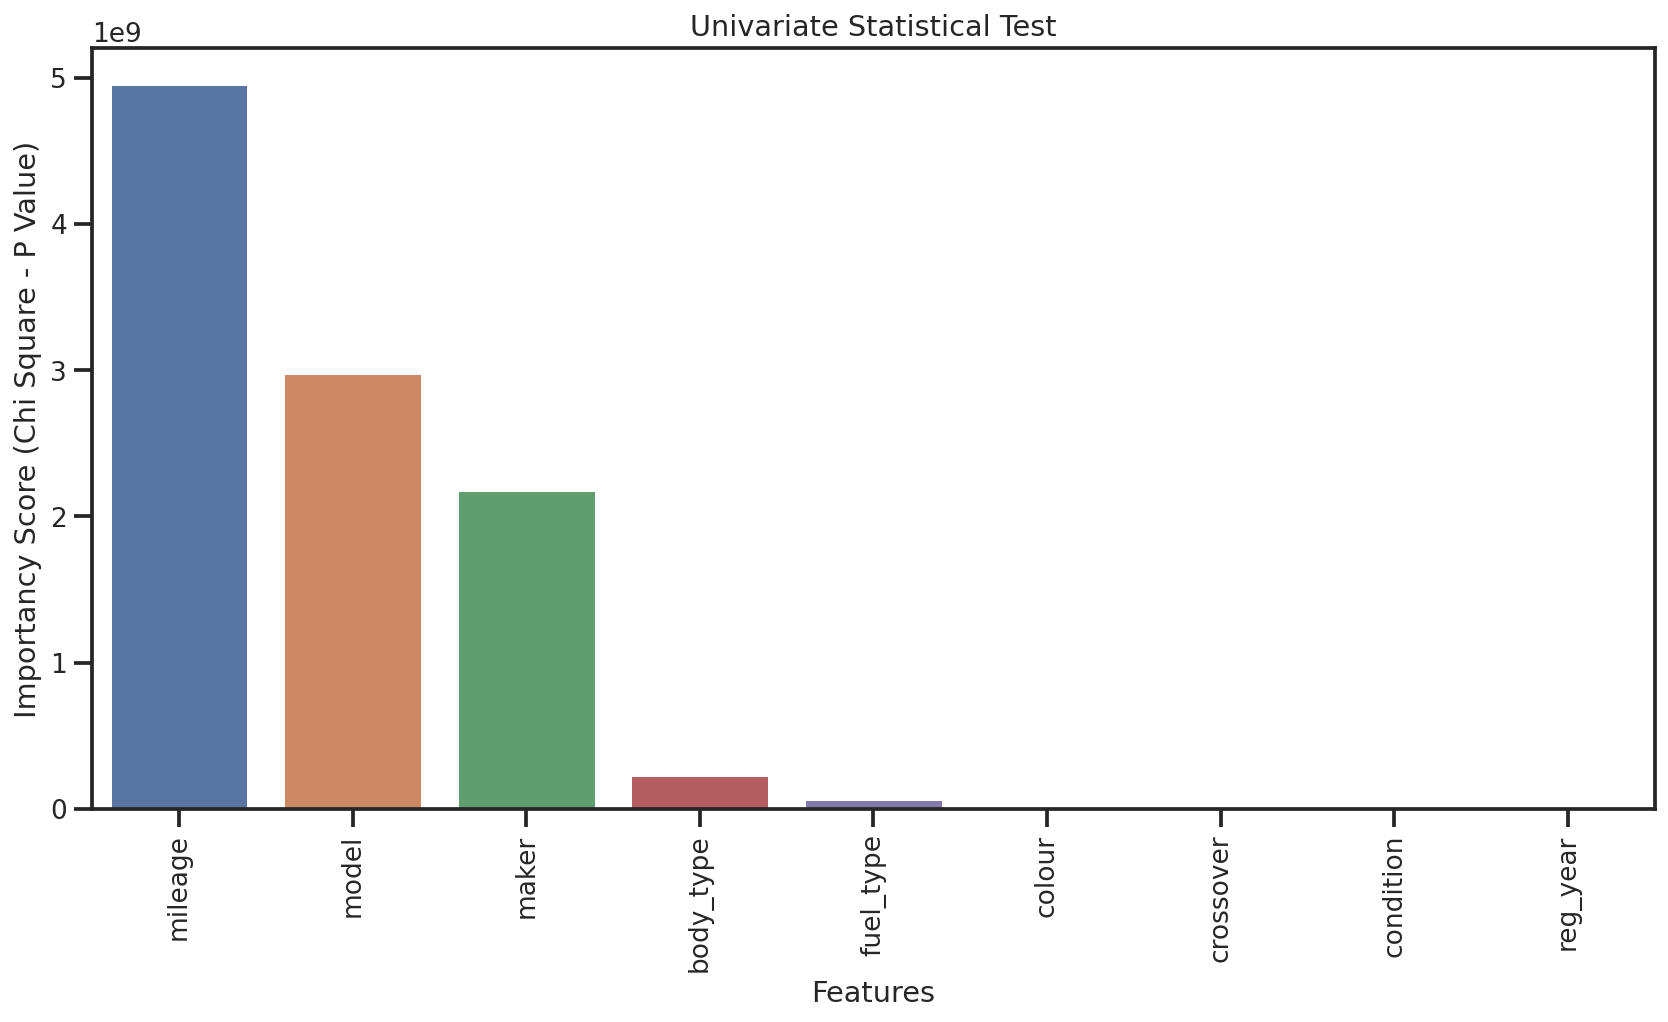

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 

feature_ranks = SelectKBest(score_func = chi2, k=X.shape[1]); # I use Chi suqare as a scoring function, and k determines the number of features I want to score
feature_ranks.fit(auto_X_train, auto_y_train); # Fiting the train data in the SelectKBest

feature_ranks = pd.concat(
                      
                      [pd.DataFrame(auto_X_train.columns,columns=["column_name"]),   #Concatinating score with their correspondent feature names
                      pd.DataFrame(feature_ranks.scores_, columns=["score"])], 
                      axis=1
)

plt.figure(figsize = (14,7))
g = sns.barplot(data = feature_ranks.sort_values(by="score", ascending=False), x="column_name", y="score")
g.set_xticklabels(g.get_xticklabels(), rotation=90);
g.set_xlabel("Features")
g.set_ylabel("Importancy Score (Chi Square - P Value)");
g.set_title("Univariate Statistical Test");


From the figure above, I can conclude that the `model`, `mileage` and `maker` have significantly high score towards the target. In contrast, the `reg_year`, `condition`, `crossover`, `fuel_type` and `colour` features are having almost no influence on the target. 

#### 5.3 Mutual information regression (MIR)
MIR is a feature selection method that uses mutual information to quantify the dependence between a feature and the target variable in a regression problem

> The runtime of following block of code is ~1 min 

In [ ]:
from sklearn.feature_selection import mutual_info_regression

feature_ranks = mutual_info_regression(auto_X_train, auto_y_train)

Text(0.5, 1.0, 'Mutual Information Regression')

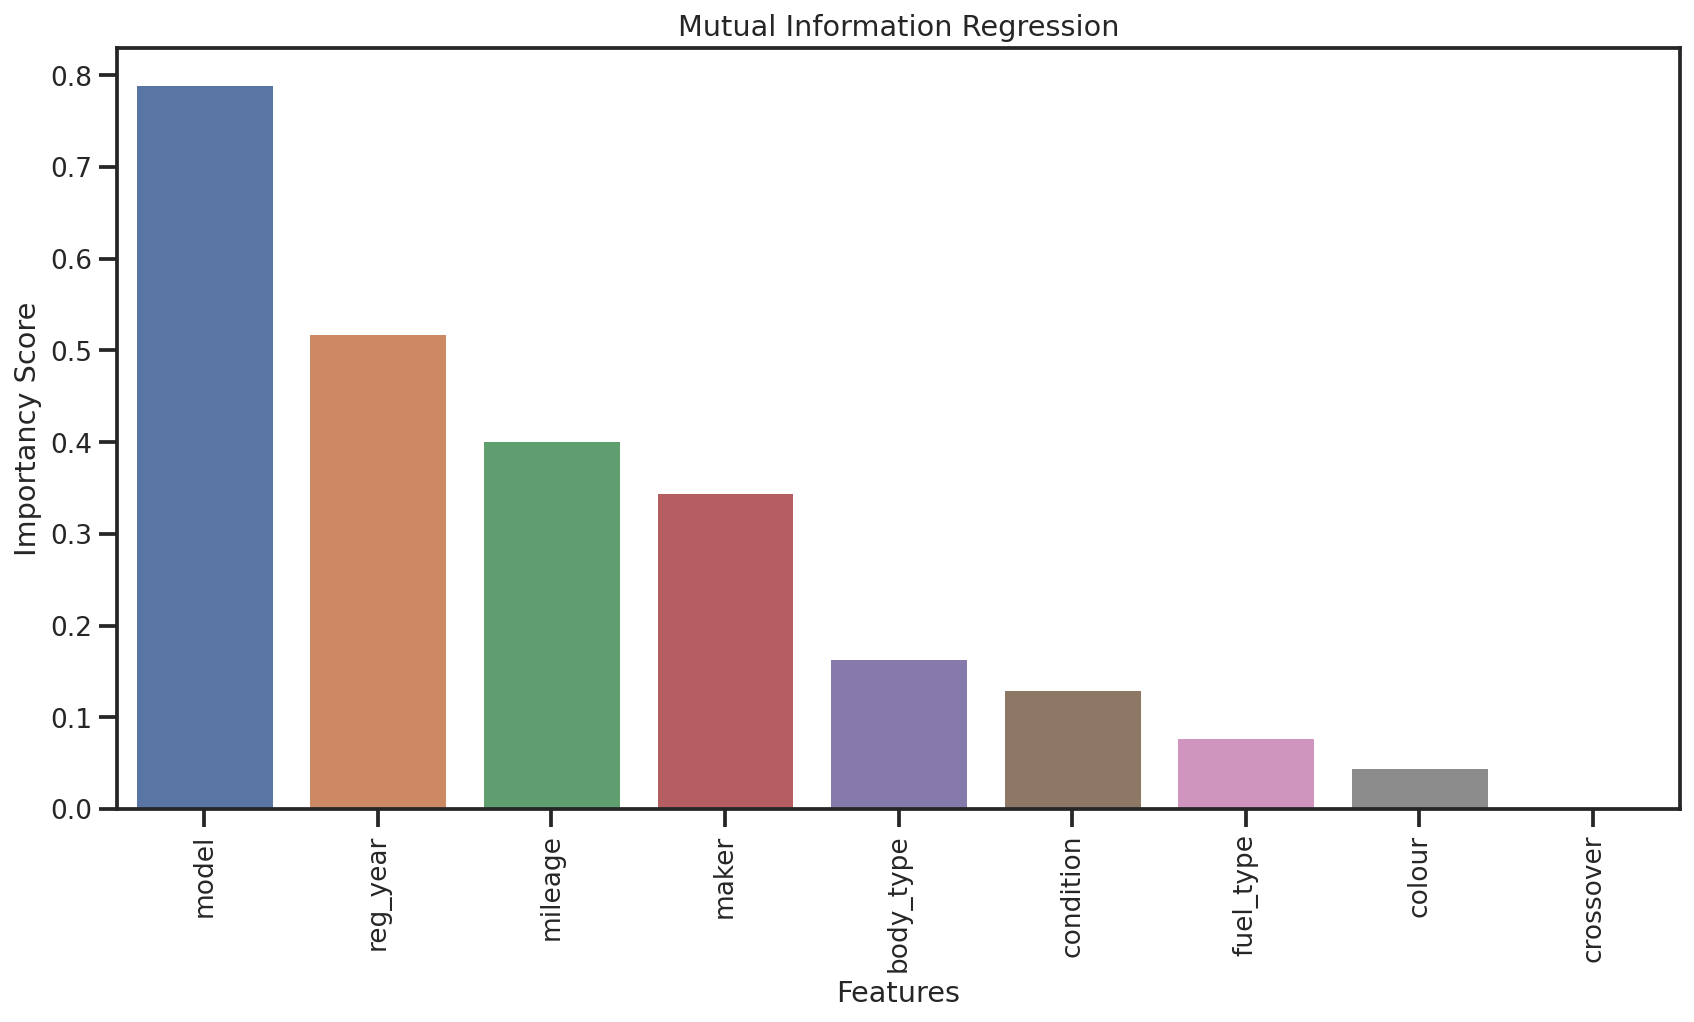

In [ ]:
feature_ranks = pd.concat(
                      
                      [pd.DataFrame(auto_X_train.columns,columns=["column_name"]),   #Concatinating score with their correspondent feature names
                      pd.DataFrame(feature_ranks, columns=["score"])], 
                      axis=1
)

plt.figure(figsize = (14,7))
g = sns.barplot(data = feature_ranks.sort_values(by="score", ascending=False), x="column_name", y="score")
g.set_xticklabels(g.get_xticklabels(), rotation=90);
g.set_xlabel("Features")
g.set_ylabel("Importancy Score")
g.set_title("Mutual Information Regression")

From the figure above, I can conclude that the `model`, `reg_year`, `mileage`, `maker`, and `body_type` have significantly high score towards the target. In contrast, the `condition`, `fuel_type`, `colour` and `crossover` features are having less influence on the target. 

**Takeaways from this section:**

1. `model`, `reg_year`, `mileage`, `maker` and `body_type` are having strongest associaten to the target. 
2. `condition`, `fuel_type`, `colour` and `crossover` are having weakest association with the target. 
3. `reg_year` is having a high colliniarity with the `mileage`. Also, `reg_year` had a very weak score when tested with Univariate Statistical Test. Therfore, it might be better to drop the `reg_year` 
4. `model` and `maker` are having a high colliniarity, and are both having strong association with the target. The best decision here would be to keep both of them, despite having their high-cardinality in their values.

> I have tried to reduce the high-cardinality of the `maker` and `model` of the cars, but removing them was not making sense for me due to their importance in the predictions. For example, there are a very few number of Ferrarri cars, but those are available are having very high prices. Due to that fact, I left them as they are and I will approach this issue in the Machine Learning part of the assignment. 